# EDA, Charts, and More!
In this file, we use the training data (split in the previous file into train/test) as the input.
<br> This file combines all EDA's and charts done across all features. We decided to separate the EDA from data preprocessing plus feature engineering to improve readability. The EDA informed us of what features and data cleaning needed to be done plus gave us insights into how there variables might affect our target variable AdoptionSpeed.

## Imports for all EDA

In [1]:
# Remove warning prints
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import heatmap
from wordcloud import WordCloud
import openpyxl
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import csv
import json
import flatten_json

# For looking at the images
from IPython.display import Image, display

## Upload training data to explore

In [3]:
# Universal to entire EDA 
file_path = './data/' #make sure this is the correct path for you
train_file = 'split_train.csv' #created at end of file 1 (parse and merge)

# Import main df
train = pd.read_csv(train_file)
columns = train.columns

# Additional files 
breed_lbl = 'PetFinder-BreedLabels.csv'
color_lbl = 'PetFinder-ColorLabels.csv'
state_lbl = 'PetFinder-StateLabels.csv'

#labels for numbered categorical features
breeds = pd.read_csv(file_path+breed_lbl)
colors_labels = pd.read_csv(file_path+color_lbl)
states = pd.read_csv(file_path+state_lbl)

# Alberto EDA - Charts

## Helper functions

In [4]:
# Helper function to plot table breakdown
def table_breakdown_adoption(df, target):
    
    # Check if column_name exists in the DataFrame
    if target not in df.columns:
        raise ValueError(f"Column '{target}' does not exist in the DataFrame.")
        
    # Create count by AdoptionSpeed and target col
    percentage_df = df.groupby([target, 'AdoptionSpeed']).size().reset_index(name='count')
    
    # Obtain percentages
    percentage_df['percentage'] = percentage_df.groupby(target, group_keys=False)['count'].apply(lambda x: (x / x.sum()) * 100)
    percentage_df['percentage'] = round(percentage_df['percentage'],1)
    
    # Sort result
    percentage_df = percentage_df.sort_values([target, 'AdoptionSpeed'])
    return percentage_df

In [5]:
# Helper function to plot countplot
def plot_breakdown_adoption(df, target, hue='AdoptionSpeed', title=''):
    
    # Check if column_name exists in the DataFrame
    if target not in df.columns:
        raise ValueError(f"Column '{target}' does not exist in the DataFrame.")
    
    # Plot
    graph = sns.countplot(x=target, data=df, hue=hue)
    plt.title(f'AdoptionSpeed by {title}');

## Feature: Name

<b> Name: Text-based feature. Name of pet (Empty if not named) </b>
 - Circa 7,500 unique names. 
 - Top names have very low frequency for both cats and dogs
 - Some NAs and non-descriptive inputs 

In [6]:
# Unique names
print(f'Number of unique names: {train.Name.nunique()}')
print("")

# Top dog names
print('--- Top dog names --')
print(train.loc[train['Type'] == 1, 'Name'].value_counts()[:5])
print("")

# Top cat names
print('-- Top cat names --')
print(train.loc[train['Type'] == 2, 'Name'].value_counts()[:5])

Number of unique names: 7460

--- Top dog names --
Brownie    37
Lucky      34
Puppy      34
Max        31
Baby       29
Name: Name, dtype: int64

-- Top cat names --
Kitty      31
No Name    29
Kittens    29
Mimi       27
Baby       24
Name: Name, dtype: int64


In [7]:
# Number of Name NAs
train.loc[train['Type'] == 1, 'Name'].isna().sum()

524

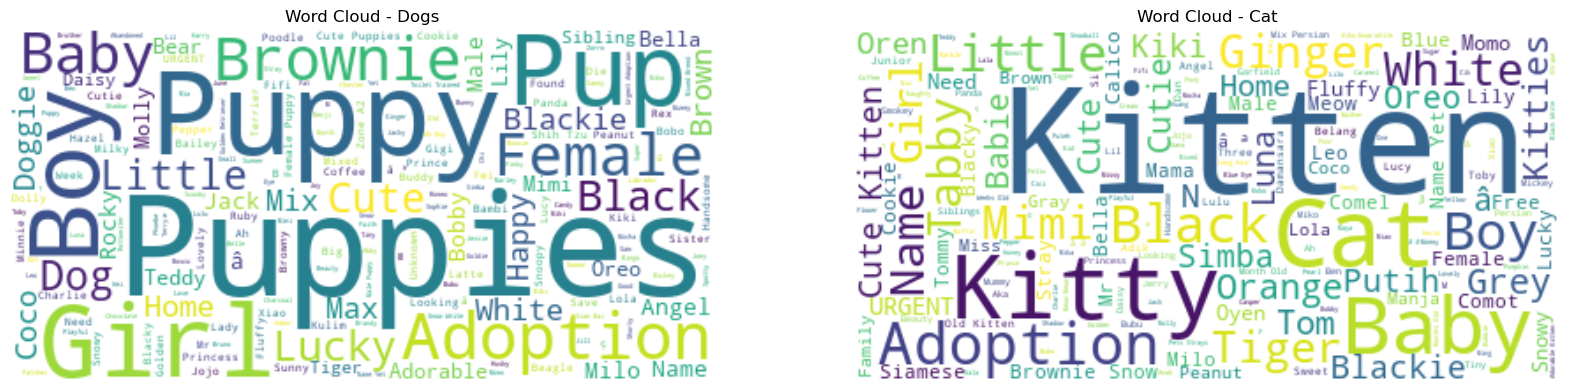

In [8]:
# Worldcloud of names
fig, ax = plt.subplots(figsize = (20,20))
plt.subplot(1,2,1)

# Plot wordcloud_dog
dog_text = ' '.join(train.loc[train['Type'] == 1, 'Name'].fillna('').values)
wordcloud_dog = WordCloud(background_color='white').generate(dog_text)
plt.imshow(wordcloud_dog, interpolation='bilinear')
plt.title('Word Cloud - Dogs')
plt.axis('off')

# Plot wordcloud_cat
plt.subplot(1,2,2)
cat_text = ' '.join(train.loc[train['Type'] == 2, 'Name'].fillna('').values)
wordcloud_cat = WordCloud(background_color='white').generate(cat_text)
plt.imshow(wordcloud_cat, interpolation='bilinear')
plt.title('Word Cloud - Cat')
plt.axis('off')
plt.show()

## Feature: RescuerID

<b> RescuerID: Text/Alphanumeric feature. ID of Rescuer</b>
 - No empty values
 - 4,800 different RescuerID. Most common RescuerID only 3% of total
 - Top RescuerIDs have slightly lower AdoptionSpeed although its such a low % that it might not matter. 

In [9]:
# Unique RescuerIDs
print(f'Number of unique RescuerID: {train.RescuerID.nunique()}')
print("")

# Value counts RescuerIDs
print('-- % of Top 5 RescuerID for Dogs --')
print(train.loc[train['Type'] == 1]['RescuerID'].value_counts(normalize=True)[:5])
print('')
print('-- % of Top 5 RescuerID for Cats --')
train.loc[train['Type'] == 2]['RescuerID'].value_counts(normalize=True)[:5]

Number of unique RescuerID: 4800

-- % of Top 5 RescuerID for Dogs --
fa90fa5b1ee11c86938398b60abc32cb    0.055785
aa66486163b6cbc25ea62a34b11c9b91    0.036986
b53c34474d9e24574bcec6a3d3306a0d    0.027205
c00756f2bdd8fa88fc9f07a8309f7d5d    0.018646
ee2747ce26468ec44c7194e7d1d9dad9    0.017118
Name: RescuerID, dtype: float64

-- % of Top 5 RescuerID for Cats --


c00756f2bdd8fa88fc9f07a8309f7d5d    0.010824
438a9bdce8ef4d5948fc40e422d34d0d    0.009723
e62135526c27156b8479420aad166317    0.008622
b770bac0ca797cf1433c48a35d30c4cb    0.006788
167119eeb94dec6c615c602952c527c8    0.005870
Name: RescuerID, dtype: float64

In [10]:
# Average AdoptionSpeed by top RescuerID for both Dogs and Cats
breeds = ['Dogs', 'Cats']
for item in [1,2]:
    grouped_df = train.loc[train['Type'] == item].groupby('RescuerID').agg({'AdoptionSpeed': ['count', 'mean']}).reset_index()
    grouped_df.columns = ['RescuerID', 'Count', 'AverageAdoptionSpeed']
    grouped_df.sort_values(by='Count', ascending=False, inplace=True)
    print(f'AdoptioSpeed by Top 5 RescuerID for {breeds[item-1]}')
    display(grouped_df[:5])

AdoptioSpeed by Top 5 RescuerID for Dogs


,RescuerID,Count,AverageAdoptionSpeed
2493,fa90fa5b1ee11c86938398b60abc32cb,365,2.405479
1749,aa66486163b6cbc25ea62a34b11c9b91,242,2.623967
1835,b53c34474d9e24574bcec6a3d3306a0d,178,2.264045
1931,c00756f2bdd8fa88fc9f07a8309f7d5d,122,2.360656
2370,ee2747ce26468ec44c7194e7d1d9dad9,112,3.071429


AdoptioSpeed by Top 5 RescuerID for Cats


,RescuerID,Count,AverageAdoptionSpeed
1887,c00756f2bdd8fa88fc9f07a8309f7d5d,59,2.389831
679,438a9bdce8ef4d5948fc40e422d34d0d,53,1.622642
2268,e62135526c27156b8479420aad166317,47,1.957447
1798,b770bac0ca797cf1433c48a35d30c4cb,37,1.810811
252,167119eeb94dec6c615c602952c527c8,32,1.531250


## Feature: Health

<b> Health: Ordinal feature. Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified) </b>
 - No empty values or 0s in the dataset
 - Healthy pets are adopted slightly faster than those with minor injuries
 - Pets with serious injuries are hard to adopt but this category is <1% of data

% breakdown of values in Health column
1    0.965316
2    0.032350
3    0.002335
Name: Health, dtype: float64


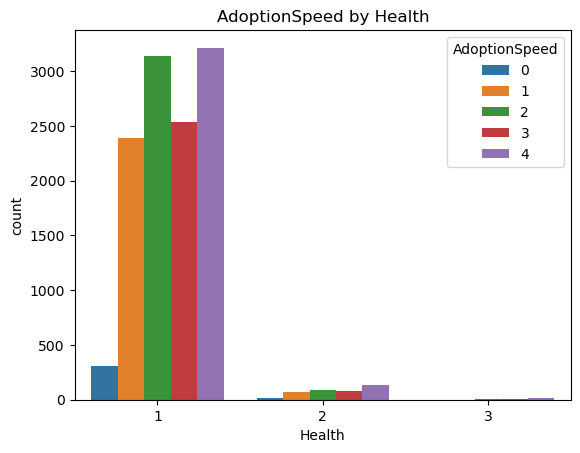

In [11]:
print('% breakdown of values in Health column')
print(train['Health'].value_counts(normalize=True))

plot_breakdown_adoption(train, target='Health', hue='AdoptionSpeed', title='Health')

In [12]:
# Apply table function to 'Health column'
table_breakdown_adoption(train, 'Health')

,Health,AdoptionSpeed,count,percentage
0,1,0,304,2.6
1,1,1,2390,20.6
2,1,2,3136,27.1
3,1,3,2533,21.9
4,1,4,3215,27.8
5,2,0,13,3.4
6,2,1,71,18.3
7,2,2,91,23.5
8,2,3,76,19.6
9,2,4,137,35.3


## Feature: Vaccinated, Dewormed

<b> Vaccianted: Nominal feature. Pet has been Vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
<br> Dewormed: Nominal feature. Pet has been Dewormed (1 = Yes, 2 = No, 3 = Not Sure)
</b>
 - No empty values 
 - Pets which are NOT vaccinated/dewormed get adopted faster (counterintuitive) 
 - Unvaccinated pets get adopted faster but these pets tend to be more cats (adopted faster), younger (also adopted faster) and in poorer health (also adopted faster). Not clear if vaccinated drives adoption or its the correlation with other features
 -  Significant overlap between the status of both categories: When a pet is not vaccinated it is unlikely to be dewormed
 - Being vaccinated or not is more important than being Dewormed. If a pet is not vaccinated, it doesnt matter much if its dewormed or not

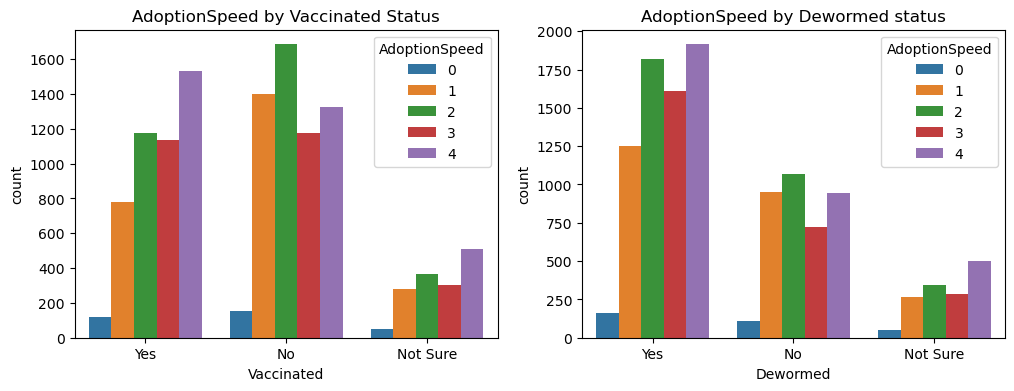

In [13]:
# Create subplots
fig, ax = plt.subplots(figsize = (12,4))

# Vaccinated subplot
plt.subplot(1,2,1)
plot_breakdown_adoption(train, target='Vaccinated', hue='AdoptionSpeed', title='Vaccinated Status')
plt.xticks([0,1,2], ['Yes', 'No', 'Not Sure']);                     

# Dewormed subplot
plt.subplot(1,2,2)
plot_breakdown_adoption(train, target='Dewormed', hue='AdoptionSpeed', title='Dewormed status') 
plt.xticks([0,1,2], ['Yes', 'No', 'Not Sure']);

In [14]:
# % of pets based on two features: Dewormed and Vaccinated
print(pd.crosstab(train['Dewormed'], train['Vaccinated'], normalize='index'))

# AdoptioSpeed by combination of Dewormed+Vaccinated
train['dew_vacc'] = train['Dewormed'].astype(str)+ 'D+' +train['Vaccinated'].astype(str)+ 'V'
print(train.groupby(['dew_vacc'])['AdoptionSpeed'].mean())
train = train.drop('dew_vacc', axis=1)

Vaccinated         1         2         3
Dewormed                                
1           0.671949  0.295172  0.032879
2           0.028202  0.967844  0.003954
3           0.069061  0.051105  0.879834
dew_vacc
1D+1V    2.670267
1D+2V    2.355243
1D+3V    2.500000
2D+1V    2.757009
2D+2V    2.370370
2D+3V    3.000000
3D+1V    2.610000
3D+2V    2.662162
3D+3V    2.644427
Name: AdoptionSpeed, dtype: float64


In [15]:
# Average of certain features by vaccination status 
train.groupby(['Vaccinated'])[['Type', 'Age', 'MaturitySize', 'Health', 'Fee', 'PhotoAmt']].mean()

,Type,Age,MaturitySize,Health,Fee,PhotoAmt
Vaccinated,,,,,,
1,1.337901,16.516442,1.941400,1.025927,35.080523,3.976813
2,1.580066,4.254748,1.787071,1.032061,11.747691,4.040077
3,1.343481,15.432826,1.858372,1.090668,13.992058,3.152879


## Feature: Sterilized

<b> Sterelized: Nominal feature. Pet has been sprayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)</b>
 - No empty values 
 - Pets which are NOT sterilized get adopted faster 
 - The above is true for most subgroups of vaccinated/dewormed status
 - The pets which are not sterelized and not vaccinated get adopted the fastest (irrespective if they are dewormed)
 - Being 'Not sure' has slightly better Adoption outcomes than being sterelized although there could be confounders
 - Most pets which are sterelized are also healthy, vaccianted and dewormed
 - Most pets for which owners are 'Not Sure' if they are sterelized, also 'Not Sure' about vaccination and dewormed
 - Overall it feels that Vaccinated and Sterilized are two important drivers

In [16]:
table_breakdown_adoption(train, 'Sterilized')

,Sterilized,AdoptionSpeed,count,percentage
0,1,0,59,2.4
1,1,1,297,12.0
2,1,2,526,21.2
3,1,3,584,23.6
4,1,4,1013,40.9
5,2,0,209,2.6
6,2,1,1882,23.4
7,2,2,2405,29.9
8,2,3,1813,22.5
9,2,4,1742,21.6


In [17]:
# Crosstab between sterilized, vaccinated and dewormed
round(pd.crosstab(
    index=[train['Sterilized'], train['Dewormed']],
    columns=train['Vaccinated'],
    values=train['AdoptionSpeed'],
    aggfunc=['count', 'mean']),2)

count             mean            
Vaccinated              1     2    3     1     2     3
Sterilized Dewormed                                   
1          1         1957   183   37  2.90  2.80  2.65
           2           27   133    1  3.22  2.99  4.00
           3           28     5  108  2.79  3.40  2.64
2          1         2292  1728  117  2.46  2.30  2.46
           2           73  3413    6  2.59  2.33  2.67
           3           37    40  345  2.46  2.20  2.49
3          1          288    82   68  2.81  2.43  2.49
           2            7   126    8  2.71  2.79  3.12
           3           35    29  821  2.63  3.17  2.71

## Feature: State

<b> State - State location in Malaysia (Refer to StateLabels dictionary) </b>
 - c90% of rows/pets come from Top 3 States (Selangor, Kuala Lumpur and Pulau Pinang)
 - There seems to be differences in AdoptionSpeed by states
 - Cats are adopted faster throughout most states except in Johor and Perak (4th and 5th state with most ads)

In [18]:
state_dict = { i:j for i,j in zip(states['StateID'], states['StateName']) }
train['State'] = train['State'].map(state_dict)

print('Value counts of State column')
train['State'].value_counts(normalize=True)[:7]

Value counts of State column


Selangor           0.581457
Kuala Lumpur       0.256378
Pulau Pinang       0.055111
Johor              0.033267
Perak              0.029098
Negeri Sembilan    0.016508
Melaka             0.009171
Name: State, dtype: float64

In [19]:
train.groupby(['State']).agg({'Type':'count', 'AdoptionSpeed':'mean'}).sort_values('Type', ascending=False)

,Type,AdoptionSpeed
State,,
Selangor,6974,2.462719
Kuala Lumpur,3075,2.533333
Pulau Pinang,661,2.791225
Johor,399,2.408521
Perak,349,2.799427
Negeri Sembilan,198,2.858586
Melaka,110,3.054545
Kedah,91,2.648352
Pahang,69,2.376812


In [20]:
train.groupby(['Type','State']).agg({'Type':'count', 'AdoptionSpeed':'mean'})

Type  AdoptionSpeed
Type State                               
1    Johor             217       2.414747
     Kedah              48       2.687500
     Kelantan            3       2.666667
     Kuala Lumpur     1369       2.628196
     Labuan              2       2.500000
     Melaka             74       3.162162
     Negeri Sembilan   109       3.165138
     Pahang             29       2.689655
     Perak             271       2.719557
     Pulau Pinang      479       2.814196
     Sabah               3       2.333333
     Sarawak             1       1.000000
     Selangor         3936       2.570122
     Terengganu          2       3.500000
2    Johor             182       2.401099
     Kedah              43       2.604651
     Kelantan           12       2.333333
     Kuala Lumpur     1706       2.457210
     Melaka             36       2.833333
     Negeri Sembilan    89       2.483146
     Pahang             40       2.150000
     Perak              78       3.076923
     Pulau Pinang      182       2.730769
     Sabah              13       2.461538
     Sarawak            10       3.400000
     Selangor         3038       2.323568
     Terengganu         22       2.636364

## Feature: Fee

<b> Fee: Adoption fee (0 = Free)</b>
 - 84% of Pets are offered for free. 
 - Of those pets which not free, majority cost less than 300 dollars
 - Preference for rounded fees (50, 100, 200...)
 - Presence of outliers (max 2,000 dollars)
 - Free pets adopted as fast as paying pets overall.  
 - However, dogs worth more than 100 dollars seem to be adopted faster. No difference for cats except few limited cases (> 500 dollars)

In [21]:
# Max fee
print(f'Max fee: {train.Fee.max()}')

# Min fee
print(f'Min fee: {train.Fee.min()}')
print('')

print('-- Distribution of values --')
train.Fee.value_counts(normalize=True)[:5]

Max fee: 2000
Min fee: 0

-- Distribution of values --


0      0.845673
50     0.030182
100    0.028014
200    0.014591
150    0.011089
Name: Fee, dtype: float64

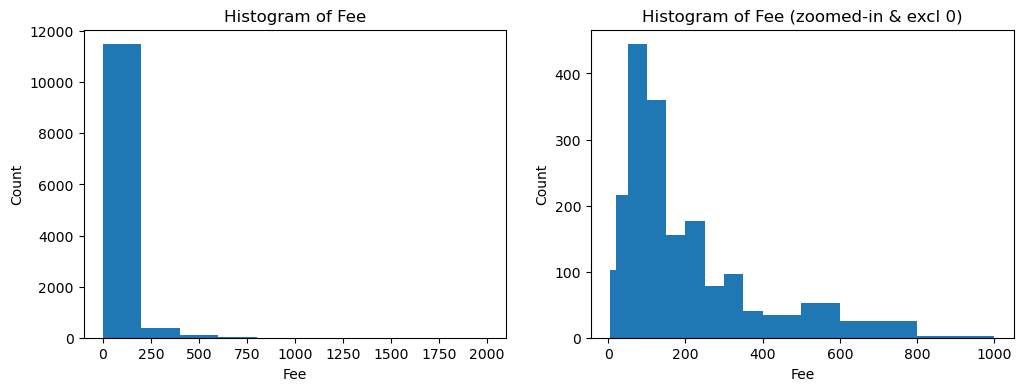

In [22]:
# Plot historgrams of Fee
fig, ax = plt.subplots(figsize = (12,4))

# Plot all data range 
plt.subplot(1,2,1)
plt.hist(x='Fee', data=train)
plt.xlabel('Fee')
plt.ylabel('Count')
plt.title('Histogram of Fee')


# Plot all data rage
plt.subplot(1,2,2)
fee_bins = [5, 20, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 800, 1000, float('inf')] 
plt.hist(x='Fee', data=train, bins=fee_bins)
plt.xlabel('Fee')
plt.ylabel('Count')
plt.title('Histogram of Fee (zoomed-in & excl 0)')

# Display the histograms
plt.show()

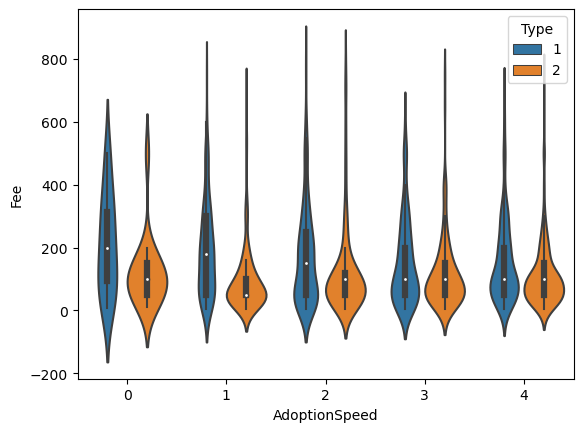

In [23]:
# Distribution of AdoptionSpeed by type and fee
sns.violinplot(data=train.loc[(train['Fee'] > 1) & (train['Fee'] < 1000)], 
               x='AdoptionSpeed', y='Fee', hue='Type');

In [24]:
# Mean AdoptionSpeed by type and Fee bucket
bins = [0, 100, 200, 300, 400, 500, 600, float('inf')]
labels = ['0', '1-100', '101-200', '201-300', '301-400', '401-500', '+500']
train.groupby(['Type', pd.cut(train['Fee'], bins=bins, labels=labels, right=False)]).agg({'Type':'count', 'AdoptionSpeed':'mean'})

Type  AdoptionSpeed
Type Fee                         
1    0        5952       2.626680
     1-100     219       2.757991
     101-200   179       2.497207
     201-300   109       2.412844
     301-400    22       2.136364
     401-500    42       2.309524
     +500       20       2.250000
2    0        5015       2.382453
     1-100     296       2.618243
     101-200    76       2.934211
     201-300    29       2.275862
     301-400    12       2.666667
     401-500    11       2.272727
     +500       12       2.416667

## Feature: Quantity

<b> Quantity: Numerical feature. Number of pets represented in profile</b>
 - No empty values. Range 1-20 pets. 
 - % of rows with more than 1 pet = 23%
 - The higher the quantity the longer it takes to adopt
 - When Quantity is between 2-5, it takes longer to adopt on average because there are more pets where AdoptionSpeed = 4 
 - When Quantity is > 5, the distribution of AdoptionSpeed shifts entirely to the right

In [25]:
# Unique values
print(f'Number of unique values Quantity: {train.Quantity.nunique()}')
print(f'Unique values Quantity: {train.Quantity.unique()}')
print('')

print('-- Distribution of values --')
train.Quantity.value_counts(normalize=True)[:5]

Number of unique values Quantity: 19
Unique values Quantity: [ 7  1  3  5  2  4  6  8 10 12 20 11  9 14 15 16 18 17 13]

-- Distribution of values --


1    0.771719
2    0.094381
3    0.048858
4    0.034517
5    0.023095
Name: Quantity, dtype: float64

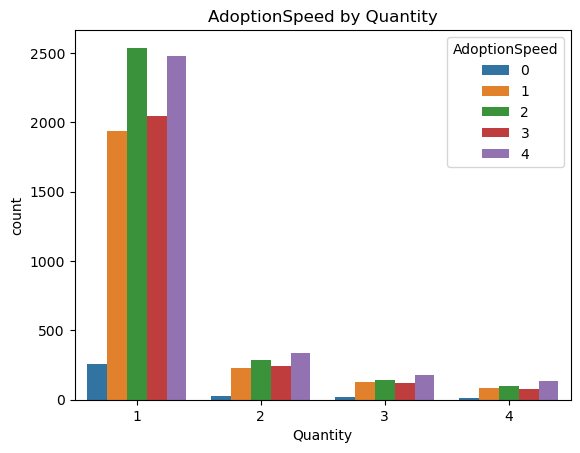

In [26]:
# Distribution of AdoptionSpeed and quantity
plot_breakdown_adoption(train.loc[train['Quantity'] < 5], 
                        target='Quantity', hue='AdoptionSpeed', title='Quantity')

In [27]:
# Distribution of AdoptionSpeed by type and quantity
train.loc[train['Quantity'] < 6].groupby(['Type','Quantity']).agg({'Type':'count', 'AdoptionSpeed':'mean'})

Type  AdoptionSpeed
Type Quantity                     
1    1         5313       2.589121
     2          495       2.660606
     3          209       2.722488
     4          171       2.824561
     5          130       2.946154
2    1         3943       2.360132
     2          637       2.486656
     3          377       2.445623
     4          243       2.440329
     5          147       2.727891

## Feature: Age

<b> Age: Numerical feature. Age of pet when listed, in months</b>
 - No empty values
 - There are "Outliers": Most pets have < 50 months (both cats and dogs) but some pets are +100 months old
 - Around 20% of pets have their Ages guessed (multiple of 12). These pets get adopted slower.

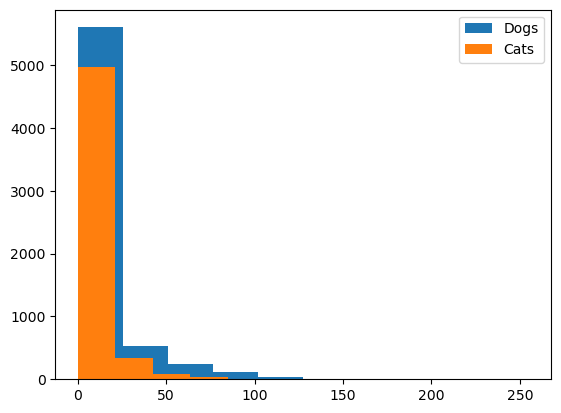

In [28]:
# Distribution of values
plt.hist(train.loc[train['Type'] == 1]['Age'], label='Dogs')
plt.hist(train.loc[train['Type'] == 2]['Age'], label='Cats')
plt.legend();

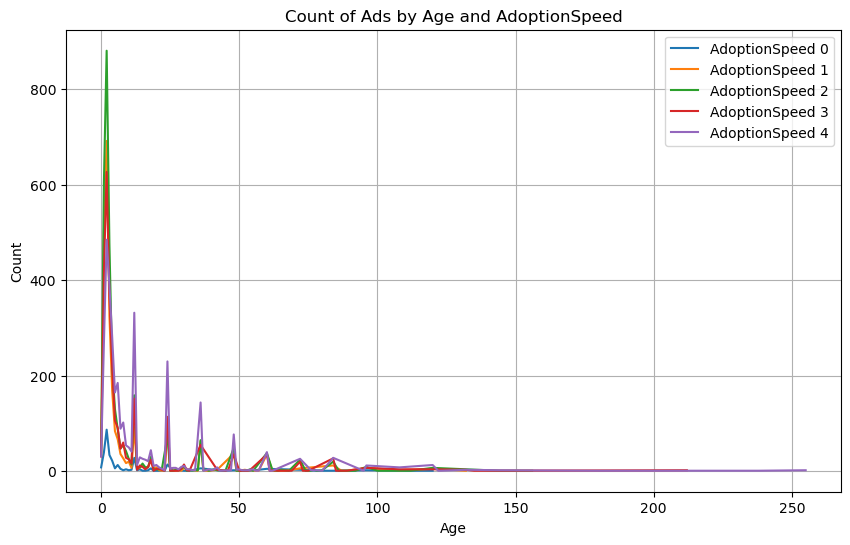

In [29]:
# Group the data by Age and AdoptionSpeed and count the rows
grouped = train.groupby(['Age', 'AdoptionSpeed']).size().reset_index(name='Count')

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Iterate over unique AdoptionSpeed values
for value in grouped['AdoptionSpeed'].unique():
    subset = grouped[grouped['AdoptionSpeed'] == value]
    plt.plot(subset['Age'], subset['Count'], label=f'AdoptionSpeed {value}')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of Ads by Age and AdoptionSpeed')
plt.legend()
plt.grid(True)
plt.show()

---
# Erik's EDA

## Part A) Initial Tabular Data Exploration

The following section of this EDA is the initial exploration of the entire tabular dataset.  The dataset was split into datatypes (categorical, ordinal, and interval) for initial review.  
This section also contains some of the visualizations utilized for baseline presentation. 

### Outcome Labels

**AdoptionSpeed** - Ordinal speed of adoption. Lower is faster. This is the value to predict. See below section for more info.

The values are determined in the following way:
 - 0 - Pet was adopted on the same day as it was listed.
 - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
 - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
 - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
 - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

### Tabular Dataset Features

**Categorical Features in Dataset**
 - Type - Type of animal (1 = Dog, 2 = Cat)
 - Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
 - Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
 - Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
 - Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
 - Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
 - Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
 - Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
 - Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
 - Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
 - State - State location in Malaysia (Refer to StateLabels dictionary)
 
**Ordinal Features in Dataset**
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

**Interval Features in Dataset**
 - Quantity - Number of pets represented in profile
 - Age - Age of pet when listed, in months
 - Fee - Adoption fee (0 = Free)
 - VideoAmt - Total uploaded videos for this pet
 - PhotoAmt - Total uploaded photos for this pet

In [4]:
#grouping features by datatype
unused_features = ["PetID", "RescuerID", "Name", "Description"]
categorical_features = ["Type", "Gender", "Vaccinated", "Dewormed", "Sterilized",
                        "Color1", "Color2", "Color3", "Breed1", "Breed2"]
ordinal_features = ["MaturitySize", "FurLength", "Health"]
interval_features = ["Quantity", "Age", "Fee", "VideoAmt", "PhotoAmt"]

***
### Defining Functions

In [5]:
#function for plotting distributions
def plot_dist(features, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for idx, ax in enumerate(axes.flatten()[:(nrows*ncols)]):
        # Define the color
        color = '#835f50'
        
        # plot histogram
        ax.hist(train[features[idx]], color=color)
        # set xlabel
        ax.set_title(features[idx])

    plt.tight_layout(h_pad=1.5)
    plt.show()

In [6]:
#function for plotting multiple boxplots
def plot_boxplots(features, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
   
    for idx, ax in enumerate(axes.flatten()[:(nrows*ncols)]):
        # Grouping the ordinal label data by categories of the categorical feature
        grouped_data = []
        categories = train[features[idx]].unique()
        for category in categories:
            grouped_data.append(train[train[features[idx]] == category]['AdoptionSpeed'])
        
        # Set the faint background color
        plt.rcParams['axes.facecolor'] = '#e2d6c7'
        
        # Plotting the box plot
        ax.boxplot(grouped_data, vert=True, labels=categories, patch_artist=True, boxprops=dict(facecolor="white"))
        
        ax.set_ylabel("Adoption Speed")
        ax.set_xlabel(categorical_features[idx])
        ax.set_title(F"Adoption Speed by {features[idx]}")

    plt.tight_layout(h_pad=1.5)
    plt.show()

In [7]:
#function for plotting presentation box plot
def box_plot(label_mapping, feature, dataset=train):
    # Modify the figure size
    plt.figure(figsize=(4, 3))

    # Set the faint background color
    plt.rcParams['axes.facecolor'] = '#e2d6c7'

    grouped_data = []
    categories = dataset[feature].unique()
    for category in categories:
        grouped_data.append(dataset[dataset[feature] == category]['AdoptionSpeed'])

    # Plotting the box plot
    boxplot = plt.boxplot(grouped_data, vert=True, patch_artist=True, labels=[label_mapping[category] for category in categories])

    box_color = 'white'
    for box in boxplot['boxes']:
        box.set(facecolor=box_color)

    plt.ylabel("Adoption Speed")
    plt.xlabel(feature)
    plt.title(f"Adoption Speed by {feature}")
    plt.xticks(rotation=45, ha="right")
    # Set y-axis to display only whole numbers
    plt.yticks(np.arange(6))

    # Set the background color with a faint version of '#c78a2e'
    ax = plt.gca()
    ax.set_facecolor('#e2d6c7')

    plt.show()

***
### Reviewing Labels

Here we look at the distribution of the labels in our dataset.

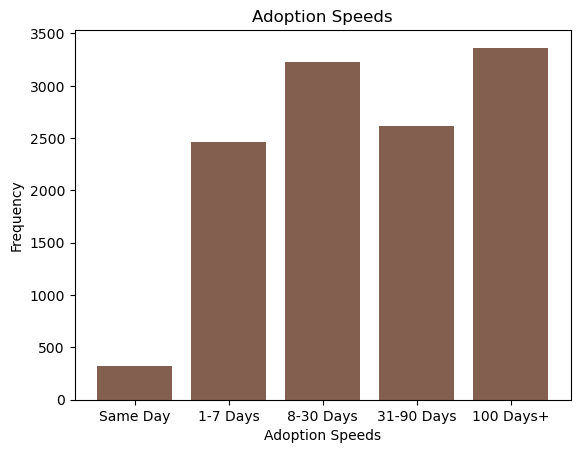

In [8]:
# Define the new labels
labels = ['Same Day', '1-7 Days', '8-30 Days', '31-90 Days', '100 Days+']

# Define the color
color = '#835f50'

# Plot the histogram with customized options
plt.hist(train['AdoptionSpeed'], bins=5, color=color, rwidth=0.8)
plt.xlabel('Adoption Speeds')
plt.ylabel('Frequency')
plt.title('Adoption Speeds')

# Get the bin edges and compute the center positions
bin_edges = np.histogram_bin_edges(train['AdoptionSpeed'], bins=5)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.xticks(bin_centers, labels)  # Set the new labels on the x-axis

plt.show()

***
### Reviewing Features By Datatype

#### Categorical Features

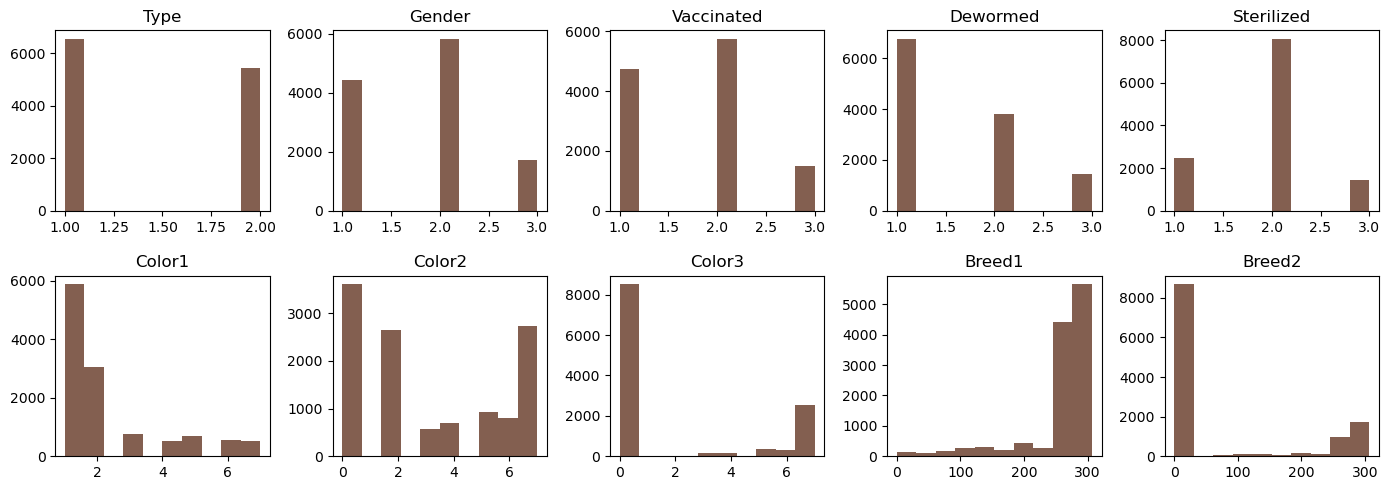

In [9]:
#plotting categorical distributions
plot_dist(categorical_features, 2, 5, (14,5))

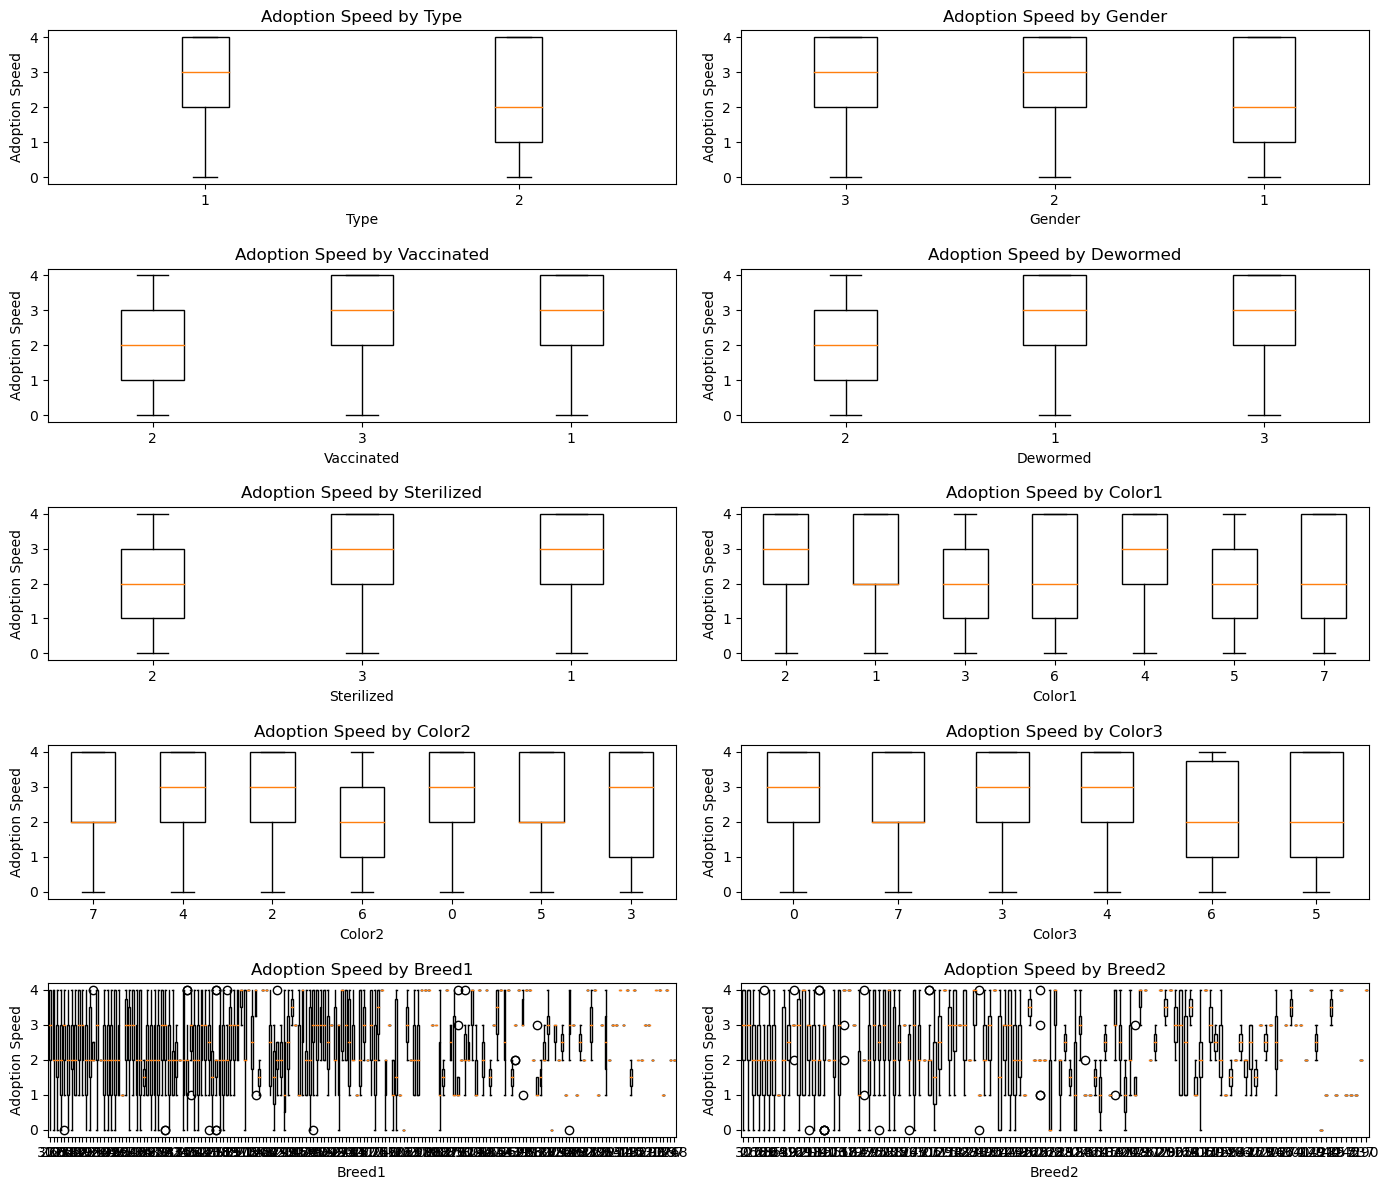

In [10]:
#plotting categorical boxplots
plot_boxplots(categorical_features, 5, 2, (14,12))

#### Plotting Individual Boxplots for Presentation

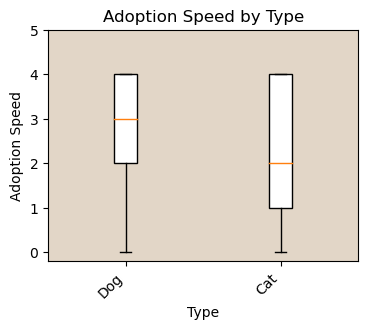

In [11]:
#Type
label_mapping = {1: 'Dog', 2: 'Cat'}
box_plot(label_mapping, 'Type')

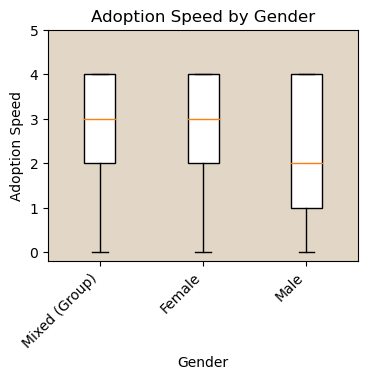

In [12]:
#Gender
label_mapping = {1: 'Male', 2: 'Female', 3: 'Mixed (Group)'}
box_plot(label_mapping, 'Gender')

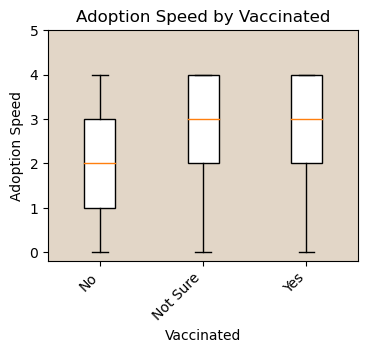

In [13]:
#Vaccinated
label_mapping = {1: 'Yes', 2: 'No', 3: 'Not Sure'}
box_plot(label_mapping, 'Vaccinated')

In [14]:
#checking popular breeds
train.Breed1.value_counts()

307    4754
266    2885
265    1029
299     264
264     228
       ... 
98        1
257       1
99        1
58        1
248       1
Name: Breed1, Length: 174, dtype: int64

In [15]:
#creating temp df of just the popular breeds to plot
label_mapping = {307: 'Mixed Breed',
                 266: 'Domestic Short Hair', 
                 265: 'Domestic Medium Hair',
                299: 'Tabby',
                264: 'Domestic Long Hair'}
# List of values to filter
filter_values = [307,266,265,299,264]

# Filter the DataFrame
top_5_breeds = train[train['Breed1'].isin(filter_values)]
top_5_breeds

,Unnamed: 0,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,petID,sent_scores,sent_magnitudes,doc_scores,doc_magnitudes,languages,text,StateName,state_population,median_state_income
0,6786,1,7 Puppies,1,307,0,3,2,7,0,...,2eb4fa594,"[0.9, 0, 0.8, 0.6]","[0.9, 0, 0.8, 0.6]",0.6,2.5,en,['Puppies for adoption- PJ Tropicana~ Adorable...,Selangor,6555100,2725.0
1,9837,1,A88,2,307,307,2,2,7,0,...,ce768b010,[0],[0],0.0,0.0,en,['For Adoption'],Selangor,6555100,2725.0
2,7688,2,Baby Kittens,1,266,266,3,1,4,7,...,3d889fe46,"[0, 0.1, 0]","[0, 0.1, 0]",0.0,0.2,en,"['Kittens age approx 2 weeks.', 'Found them ne...",Selangor,6555100,2725.0
4,11322,1,Jack,2,307,0,3,2,4,7,...,14bbc5876,"[0, 0.2, 0.7, -0.2, 0.2]","[0, 0.2, 0.7, 0.2, 0.2]",0.2,1.7,en,['The puppy Borned outside our house front gat...,Perak,2509000,1629.0
5,820,2,"M'sia Day Kitty:Boyboy,YY & Girlgal",3,266,265,3,3,6,7,...,55f34f8f5,"[0, 0, 0.1, 0.9, 0.5]","[0, 0, 0.1, 0.9, 0.5]",0.4,1.7,en,"['(From left, as at profile picture) Dark gray...",Selangor,6555100,2725.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11988,11964,1,Stella,3,307,0,2,2,7,0,...,7ed14130d,"[0.9, -0.1, 0.2]","[0.9, 0.1, 0.2]",0.3,1.3,en,['Lovely puppy looking for a home sweet home.'...,Selangor,6555100,2725.0
11990,13418,1,Hearty,3,307,0,2,5,7,0,...,360215e23,"[0, 0.7, 0.1]","[0, 0.7, 0.1]",0.3,0.9,en,"['Little puppy rescued and handraised.', 'very...",Kuala Lumpur,1746600,3037.0
11991,5390,2,Arwen,12,266,0,2,7,0,0,...,0c612e8df,"[0.7, 0, -0.3, 0, 0.2, 0.1]","[0.7, 0, 0.3, 0, 0.2, 0.1]",0.1,1.5,en,"[""Arwen is a gentle young mother cat who turne...",Selangor,6555100,2725.0
11992,860,2,Shy Kittens,5,266,0,2,1,4,5,...,9b1241ef0,"[0.8, -0.8, 0.7]","[0.8, 0.8, 0.7]",0.2,2.4,en,['Previously I have successfully find adopter ...,Kuala Lumpur,1746600,3037.0


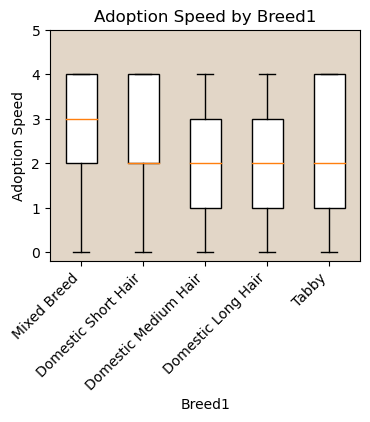

In [16]:
#top five Breeds
box_plot(label_mapping, 'Breed1', top_5_breeds)

In [17]:
#checking specific breeds
train[train['Breed1']==60].shape

(27, 46)

#### Ordinal Features

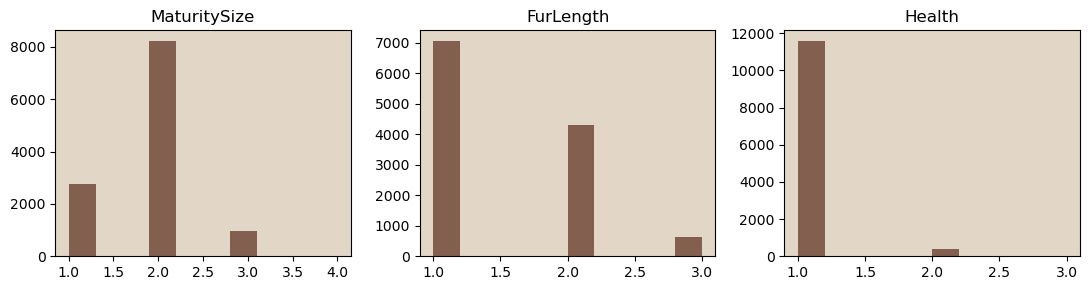

In [18]:
#plotting distribution of ordinal features
plot_dist(ordinal_features, 1, 3, (11,3))

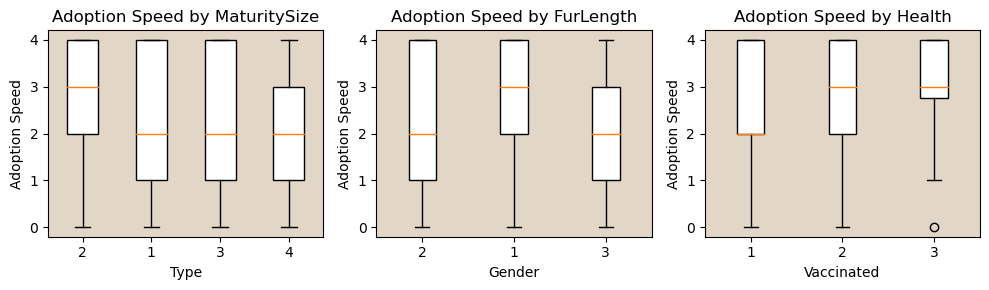

In [19]:
#plotting ordinal boxplots
plot_boxplots(ordinal_features, 1, 3, (10,3))

### Interval Features

To discuss:
 - **Quantity**:  Some of these individual records are representative of multiple pets.  As I understand from the documentation, the adoption speed of these "groups" is based on when ALL pets of the group have been adopted. **Should we drop these 3,428 groups from our datasets?**
 
 - **Fee**: The majority of records have 0 fee.  However there are 44 records with fee's over $500.  **Does it make sense to turn this into a binary variable? fee/no fee? Or drop heavy fee outliers?"**
 
 - **Videos**: We do not have the actual videos as part of the dataset, only the amount that were provided. Only about 500 included a video. **Should we make a binary, included/didn't include video?**
 
 - **Images**: There are 341 records without photos.  **Do we want to have any inclusion in the model on number of photos present? Or just on the content of the photos themselves?  If we are using content of photos, is there an issue with records having disproportinate photos associated with them?**


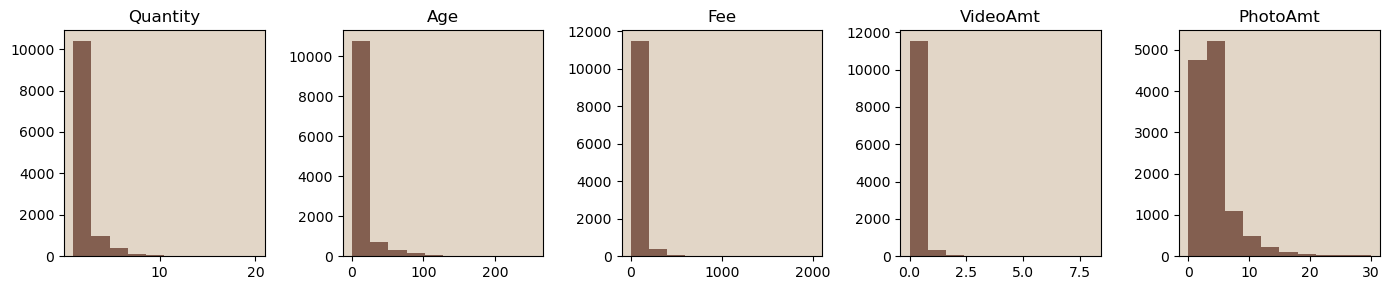

In [20]:
#plotting interval distributions
plot_dist(interval_features, 1, 5, (14,3))

In [21]:
#checking photo amount counts
train.PhotoAmt.value_counts()

1.0     2451
2.0     2036
3.0     2001
5.0     1696
4.0     1512
6.0      484
7.0      343
8.0      268
0.0      267
9.0      188
10.0     155
11.0     143
12.0      81
13.0      67
14.0      66
15.0      46
16.0      34
20.0      18
17.0      17
19.0      16
18.0      15
30.0      15
24.0      15
21.0      12
23.0      10
22.0       8
28.0       7
26.0       7
25.0       6
27.0       6
29.0       4
Name: PhotoAmt, dtype: int64

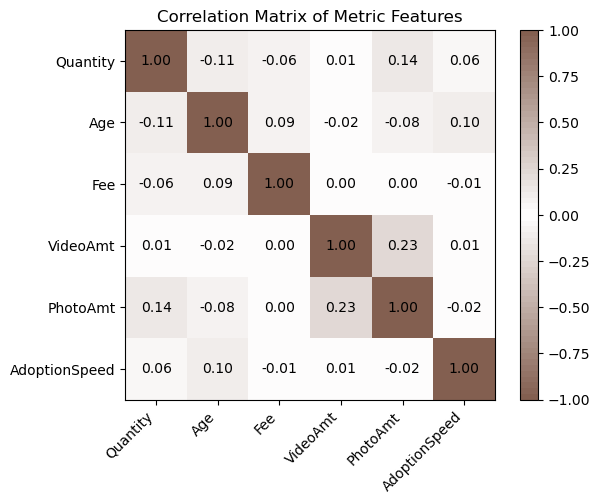

In [22]:
#plotting Correlation Matrix for Interval Data
from matplotlib import colors

# Define the variables and correlation matrix
variables = interval_features + ['AdoptionSpeed']
cm = train[variables].corr().values

# Define the custom colormap
colors_list = ['#835f50', '#FFFFFF', '#835f50']  # Dark brown to white
cmap = colors.LinearSegmentedColormap.from_list('custom_colormap', colors_list, N=64)

# Set the color range
color_min = -1.0
color_max = 1.0

# Create the heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(cm, cmap=cmap, vmin=color_min, vmax=color_max)

# Display the values in each cell
for i in range(len(variables)):
    for j in range(len(variables)):
        text = ax.text(j, i, "{:.2f}".format(cm[i, j]),
                       ha="center", va="center", color="black")

# Set the x-axis and y-axis ticks and labels
ax.set_xticks(np.arange(len(variables)))
ax.set_yticks(np.arange(len(variables)))
ax.set_xticklabels(variables)
ax.set_yticklabels(variables)

# Rotate the x-axis tick labels for better visibility
plt.xticks(rotation=45, ha="right")

# Add a colorbar
cbar = plt.colorbar(heatmap)

# Set the title
plt.title("Correlation Matrix of Metric Features")

# Display the plot
plt.show()

In [23]:
train['Photo Present'] = train['PhotoAmt'] > 0

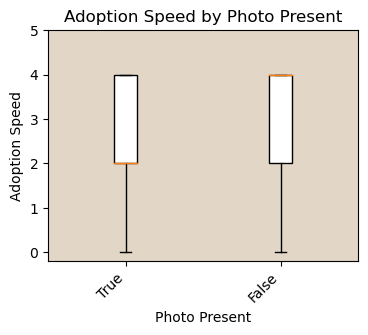

In [24]:
#plotting binary photo present boxplot
label_mapping = {True: 'True', False: 'False'}
box_plot(label_mapping, 'Photo Present')

***
## Part 2) EDA of Specific Features for Engineering

This section is exploring in-depth the following features to identify any feature engineering or transformations necessary.  Please see File 3 for list of transformations and feature engineering completed for these features
    
**Categorical Features in Dataset** 
 - Type - Type of animal (1 = Dog, 2 = Cat)
 - Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
 - Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
 - Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
 - Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
 - Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
 - Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
 
**Ordinal Features in Dataset**
 - MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
 - FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
 
**Interval Features in Dataset**
 - VideoAmt - Total uploaded videos for this pet
 - PhotoAmt - Total uploaded photos for this pet 

***
### Define Functions

**PLEASE NOTE:** 
 - **Post-Engineering EDA** - Reviewing these features was an iterative process where similar EDA was performed before and after feature engineering.  The following code is designed to work the features 'post-engineering'.  For that reason, I am including a function here to create a temp dataset with the applied engineering so that this section can be run.  For the actual feature transformations and engineering used for modeling, please see File 3.
 - **Breed Groups** - An attempt was made to create breed groups.  There is a completely seperate notebook that was used for this exercise.  The result of that exercise, with some additional manual efforts, resulted in an updated breed label file which is being uploaded in the following section.  We ended up not using this feature.  

In [25]:
#uploading updated breed label file
breed_lbl = 'updated_breed_lbls.csv'
breeds = pd.read_csv(breed_lbl)

def temp_app_eriks_engineering (train, colors, breeds):
    #Type - transforming all 2's to 0's
    train['Type'] = train['Type'].replace(2, 0)

    #has_Video - transforming all non 0's to 1's
    train['has_Video'] = (train['VideoAmt'] != 0).astype(int)

    #has_Photo - transforming all non 0's to 1's
    train['has_Photo'] = (train['PhotoAmt'] != 0).astype(int)

    #MaturitySize - replacing all 0's with -1's
    train['MaturitySize'] = train['MaturitySize'].replace(0, -1)

    #Maturity_isSpecified
    train['Maturity_isSpecified'] = (train['MaturitySize'] != 0).astype(int)

    #FurLength - replacing all 0's with -1's
    train['FurLength'] = train['FurLength'].replace(0, -1)

    #FurLength_isSpecified
    train['FurLength_isSpecified'] = (train['FurLength'] != 0).astype(int)

    #isMale - transform to binary
    train['isMale'] = train['Gender'].apply(lambda x: 1 if x == 1 or x == 3 else 0)

    #isFemale - transform to binary
    train['isFemale'] = train['Gender'].apply(lambda x: 1 if x == 2 or x == 3 else 0)

    #{Color} - OHE for presence of each color
    for color_num, color in zip(colors['ColorID'], colors['ColorName']):
        train[color] = train[['Color1', 'Color2', 'Color3']].apply(lambda row: 1 if color_num in row.values else 0, axis=1)

    #ColorCount
    color_columns = colors['ColorName'].tolist()
    train['ColorCount'] = train[color_columns].sum(axis=1)

    #isGeneric_Breed
    #identifying the 4 IDs for breeds that are generic 'mixed-breed, domestic-short/medium/long hair
    generic_breeds = [307,264,265,266]
    train['isGeneric_Breed'] = train[['Breed1', 'Breed2']].apply(
        lambda row: 1 if all(breed in generic_breeds or breed == 0 for breed in row) else 0,axis=1)
    
    #{Breed_Group} - OHE for presence of breed group
    for breed_num, breed in zip(breeds['BreedID'], breeds['Group']):
        train[breed] = train[['Breed1', 'Breed2']].apply(lambda row: 1 if breed_num in row.values else 0, axis=1)
    return train

In [26]:
# Creating the temp dataframe to apply above transformations for this section
temp_train = train
temp_train = temp_app_eriks_engineering(temp_train, colors_labels, breeds)

In [27]:
#function for plotting box plot
def box_plot(label_mapping, feature, dataset=temp_train):
    # Modify the figure size
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    for i, animal in enumerate(['Cat', 'Dog']):
        grouped_data = []
        categories = dataset[feature].unique()
        for category in categories:
            grouped_data.append(dataset[(dataset[feature] == category) & (dataset['Type'] == i)]['AdoptionSpeed'])

        # Plotting the box plot
        boxplot = ax[i].boxplot(grouped_data, vert=True, patch_artist=True, labels=[label_mapping[category] for category in categories])

        box_color = 'white'
        for box in boxplot['boxes']:
            box.set(facecolor=box_color)

        ax[i].set_ylabel(f"{animal} Adoption Speed")
        ax[i].set_xlabel(feature)
        ax[i].set_title(f"{animal} Adoption Speed by {feature}")
        # plt.xticks(rotation=45, ha="right")
        # Set y-axis to display only whole numbers
        ax[i].set_yticks(np.arange(6))
        
        # Add count annotations to the boxplot
        counts = [len(data) for data in grouped_data]
        positions = range(1, len(categories) + 1)
        for pos, count in zip(positions, counts):
            ax[i].annotate(str(count), xy=(pos, max(ax[i].get_ylim())), xytext=(0, -15),
                           textcoords="offset points", ha='center', va='bottom')

    # Set the background color with a faint version of '#c78a2e'
    ax[i] = plt.gca()
    ax[i].set_facecolor('#e2d6c7')

    plt.show()

In [28]:
def dist_adpt_speeds_plot(temp_train, pet_type, groupby, title, threshold=0):
    if pet_type == 1:
        pet = 'Dog'
    elif pet_type == 0:
        pet = 'Cat'
    group_breeds = temp_train[temp_train.Type==pet_type].groupby(groupby, dropna=False).agg({'PetID': 'count', 'AdoptionSpeed': 'median'})

    # Sort the DataFrame by the count of pets in descending order
    group_breeds = group_breeds.sort_values(by='PetID', ascending=False)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

    # Define the color
    color = '#835f50'

    # Create a bar plot from the GroupBy table
    group_breeds['PetID'][group_breeds['PetID'] > threshold].plot(kind='bar', ax=ax[0], color=color)

    # Add labels and title
    ax[0].set_xlabel(title)
    ax[0].set_ylabel(f'Number of {pet}')
    ax[0].set_title(f'Counts for {pet} {title}  (w/ over {threshold} Records)')

    # Reduce font size of x-axis labels
    ax[0].tick_params(axis='x', labelsize=6)  # Adjust the font size as per your preference

    # Create a bar plot from the GroupBy table
    group_breeds['AdoptionSpeed'][group_breeds['PetID'] > threshold].plot(kind='bar', ax=ax[1], color=color)

    # Add labels and title
    ax[1].set_xlabel(title)
    ax[1].set_ylabel('Median Adoption Speed')
    ax[1].set_title(f'Adoption Speed for {title}')

    # Reduce font size of x-axis labels
    ax[1].tick_params(axis='x', labelsize=6)  # Adjust the font size as per your preference

    plt.tight_layout()  # Adjust the layout

    plt.show()

---
#### Feature: Type

**Binary (1 = Dog, 0 = Cat)**

For Type, converting (1 = Dog, 2 = Cat) to (1 = Dog, 0 = Cat), to act as a binary feature.  The documentation does not mention an alternative to these two options, and there are no null or different values in the train dataset, so I am assuming this conversion suffices for this feature. 

In [29]:
temp_train['Type'].value_counts()

1    6543
0    5451
Name: Type, dtype: int64

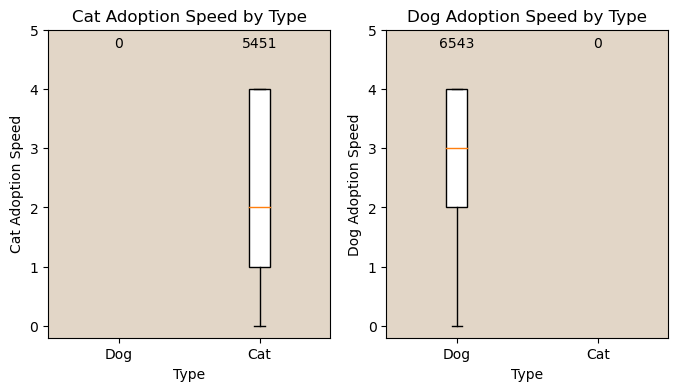

In [30]:
label_mapping = {1: 'Dog', 0: 'Cat'}
box_plot(label_mapping, 'Type')

---
#### Feature: Video Amount

**'has_Video' - Binary (1 = has video, 0 = does not have video)**

Since no actual videos are available for review, and a large majority or the records do not include a video (only 574 of ~15k do), choosing to convert this feature to binary; whether or not a video was present. 

**COMMENT: Because there is an imbalance between the classes, do we want to set our weighting to "balanced" when fitting the model? Do we want to try and experiement with SMOTE? Anyone familiar with that technique?**

In [31]:
temp_train['has_Video'].value_counts()

0    11527
1      467
Name: has_Video, dtype: int64

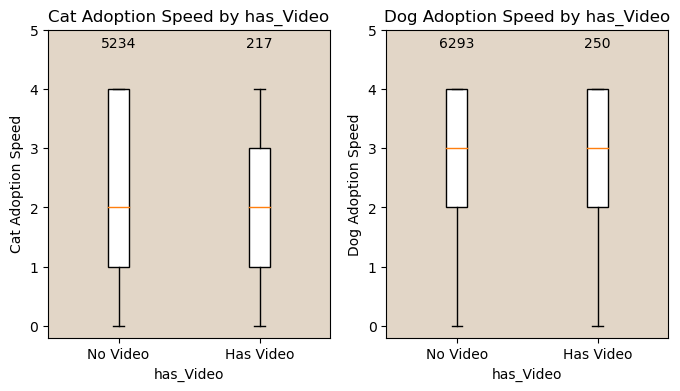

In [32]:
label_mapping = {1: 'Has Video', 0: 'No Video'}
box_plot(label_mapping, 'has_Video')

---
#### Feature: Photo Amount

**'has_Photo' - Binary (1 = has photo, 0 = does not have photo)**

Same as with videos, I think it is best to convert this to a binary feature of whether or not a photo is present.  There was very little correlation between the "amount" of photos and adoption speed, but it appeared to me a more meaninful feature when treated as binary. This feature as the opposite issue with class imbalance.  There are only a small number of records that did not come with a photo. 

**COMMENT: Same as above. . . do we set balanced weighting when fitted? Or try something like SMOTE?**

In [33]:
temp_train['has_Photo'].value_counts()

1    11727
0      267
Name: has_Photo, dtype: int64

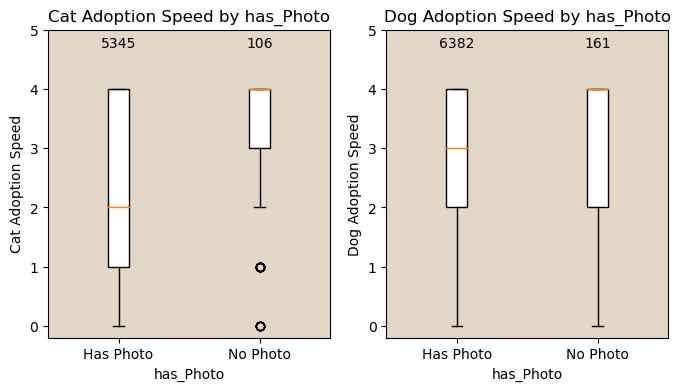

In [34]:
label_mapping = {1: 'Has Photo', 0: 'No Photo'}
box_plot(label_mapping, 'has_Photo')

---
#### Feature: MaturitySize

**'MaturitySize' - Ordinal (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large)**

**X**

**'Maturity_isSpecified' - Binary (1 = Maturity_isSpecified, 0 = Maturity_notSpecified)**

Our train dataset does not contain any records with the original '0 = unspecified' value.  However, in case it is present in the test dataset, it is important that we properly account for it.  The rest of the numeric mapping to sizes follows a proper ordinal ranking, besides the 0.  For that reason, I am removing the 0 from the ordinal feature and creating a secondary binary feature to support unspecified records. 

**COMMENTS:**
 - **Does this work? We know that the binary feature will see no values in the train model.  Is this the proper way to accommodate a value that 1) may appear in a test dataset and 2) does not follow proper ordinal ranking?**
 - **Need to learn how to properly create a model that includes two features that are multiplied by each other.**

In [35]:
temp_train.MaturitySize.value_counts()

2    8223
1    2757
3     985
4      29
Name: MaturitySize, dtype: int64

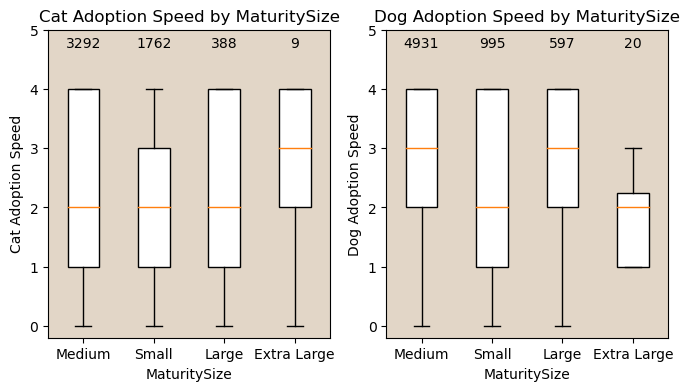

In [36]:
label_mapping = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large'}
box_plot(label_mapping, 'MaturitySize')

---
#### Feature: FurLength

**'FurLength' - Ordinal(1 = Short, 2 = Medium, 3 = Long)**

**X**

**'Fur_isSpecified' - Binary(1 = isSpecified, 0 = notSpecified)**

Treating fur length the same as Maturity Size. . . .

In [37]:
temp_train.FurLength.value_counts()

1    7060
2    4292
3     642
Name: FurLength, dtype: int64

In [38]:
temp_train.FurLength_isSpecified.value_counts()

1    11994
Name: FurLength_isSpecified, dtype: int64

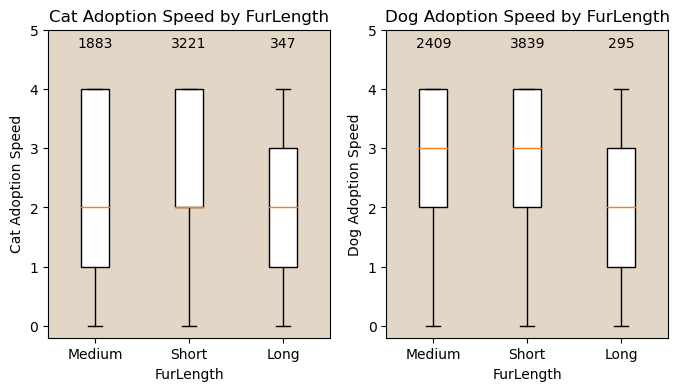

In [39]:
label_mapping = {1: 'Short', 2: 'Medium', 3: 'Long'}
box_plot(label_mapping, 'FurLength')

---
#### Feature: Gender

**'isMale' - Binary (1 = male, 0 = not_male)**

**'isFemale' - Binary (1 = female, 0 = not_female)**

The thought was to transform the Gender feature into two separate features.  One for male and one for female. While this is redundant for deciphering between a male and female, it allows both features to have a value of 1, to represent a mix of gender in the group. 

**COMMENT: The best solution here is also dependent on how we plan to approach the Quantity feature, which is representing the number of pets in a particular record.**

In [40]:
temp_train.Gender.value_counts()

2    5824
1    4432
3    1738
Name: Gender, dtype: int64

In [41]:
temp_train.isMale.value_counts()

1    6170
0    5824
Name: isMale, dtype: int64

In [42]:
temp_train.isFemale.value_counts()

1    7562
0    4432
Name: isFemale, dtype: int64

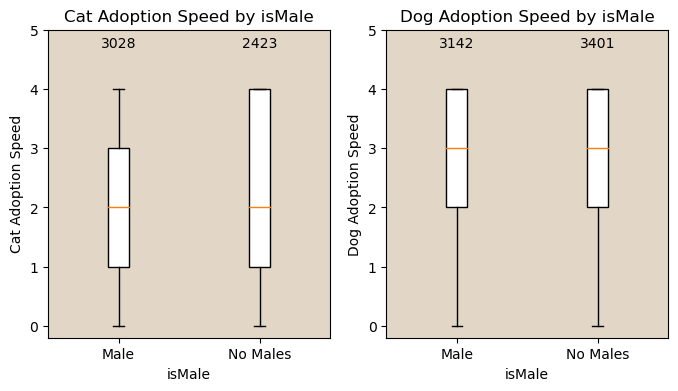

In [43]:
label_mapping = {1: 'Male', 0: 'No Males'}
box_plot(label_mapping, 'isMale')

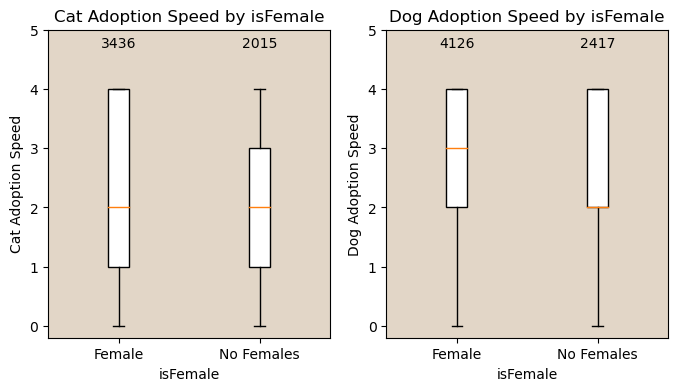

In [44]:
label_mapping = {1: 'Female', 0: 'No Females'}
box_plot(label_mapping, 'isFemale')

---
#### Feature: Color

**'{Color}' - Binary OHE (1 = color is present, 0 = color not present)**

**'ColorCount' - Interval (1 - 3 = number of colors identified)**

It does not appear that the order of the colors means anything, there does not appear to be opposite orders.  (i.e. there is Black-Brown, but no Brown-Black). So thinking it is best to create a OHE for each color that is 1 if color is present. 

In [45]:
for i in range(1,4):
    temp_train[f'Color{i}'] = temp_train[f'Color{i}'].map(colors_labels.set_index('ColorID')['ColorName'])

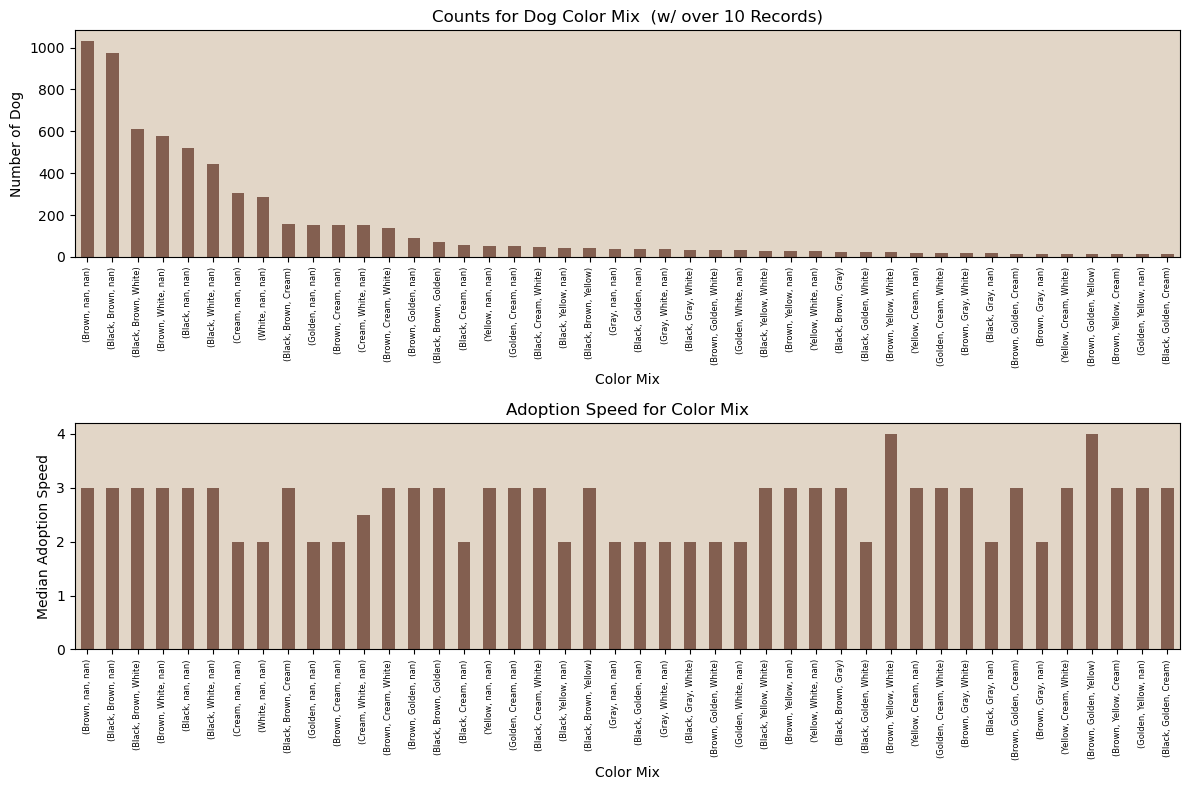

In [46]:
dist_adpt_speeds_plot(temp_train, 1, ['Color1', 'Color2', 'Color3'], 'Color Mix', threshold=10)

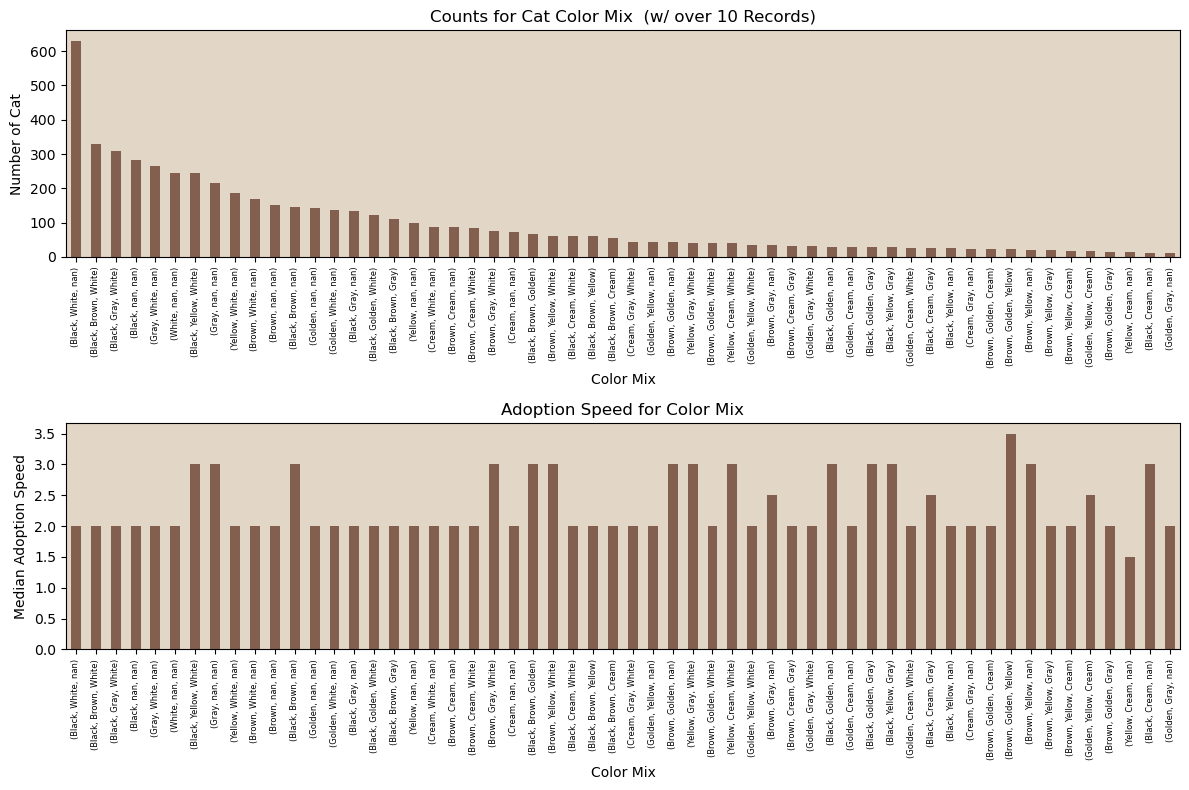

In [47]:
dist_adpt_speeds_plot(temp_train, 0, ['Color1', 'Color2', 'Color3'], 'Color Mix', threshold=10)

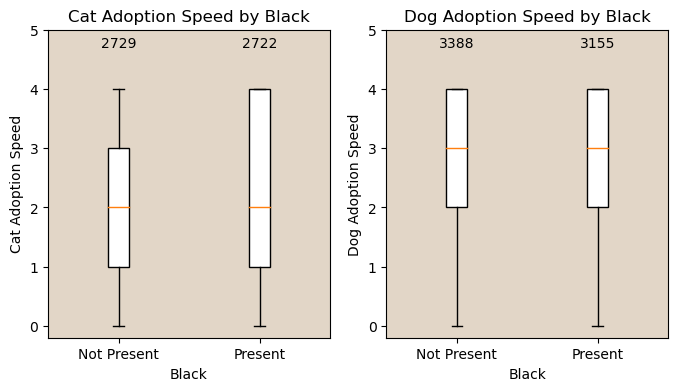

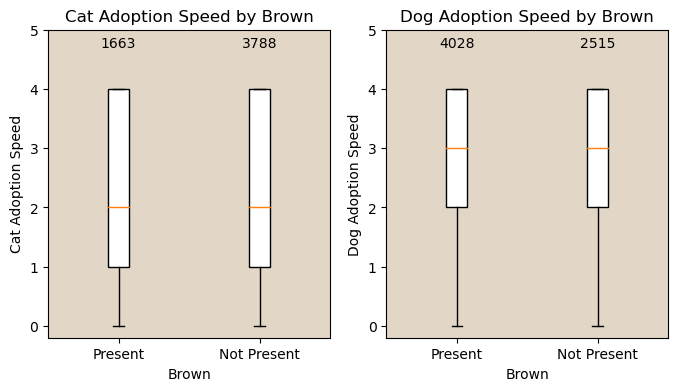

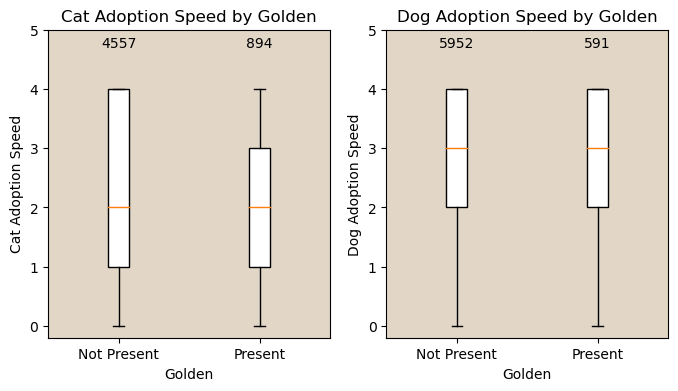

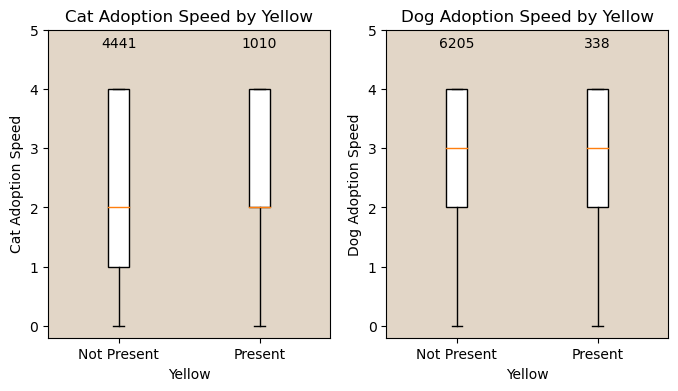

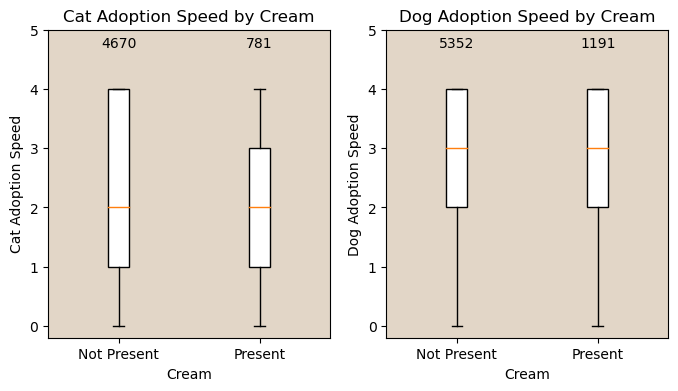

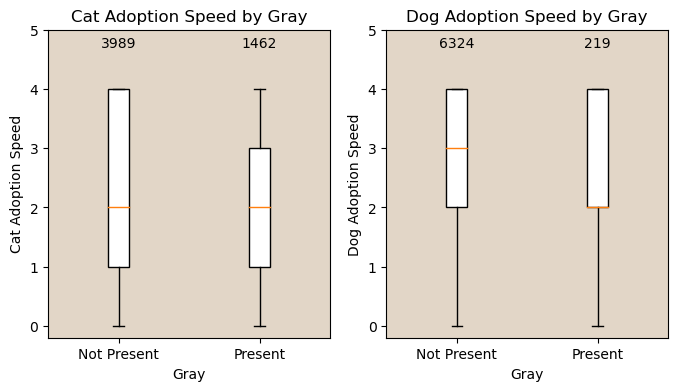

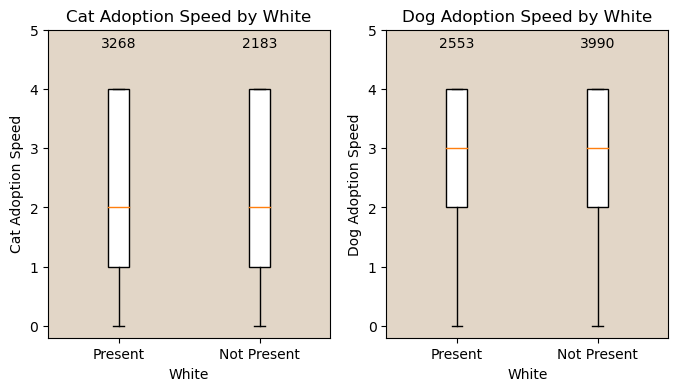

In [48]:
for color in colors_labels['ColorName']:
    label_mapping = {1: 'Present', 0: 'Not Present'}
    box_plot(label_mapping, color)

In [49]:
temp_train['ColorCount'].value_counts()

2    4905
1    3601
3    3488
Name: ColorCount, dtype: int64

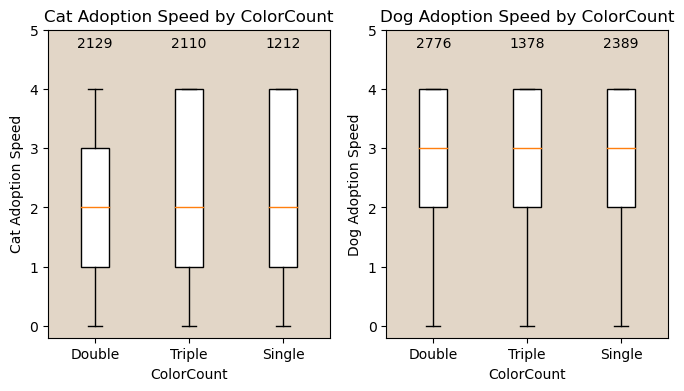

In [50]:
label_mapping = {1: 'Single', 2: 'Double', 3: 'Triple'}
box_plot(label_mapping, 'ColorCount')

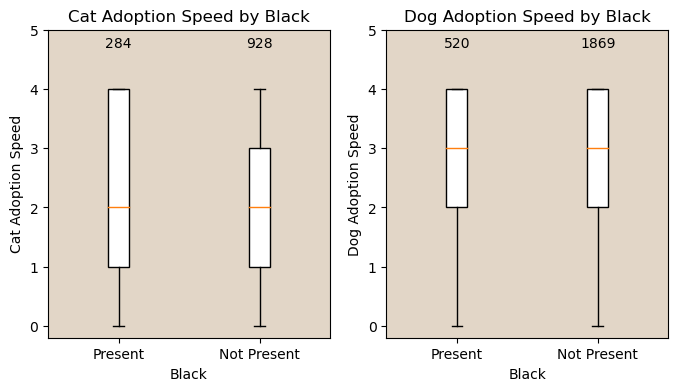

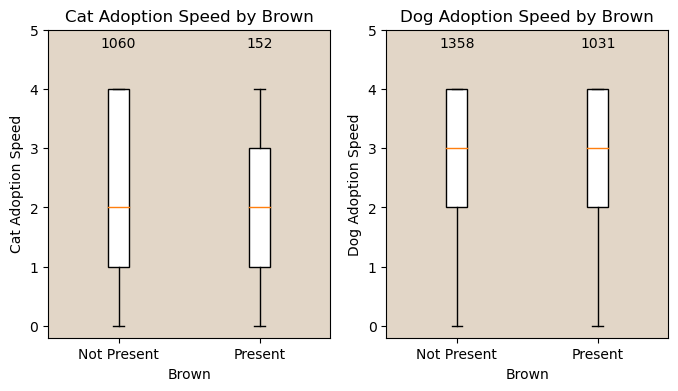

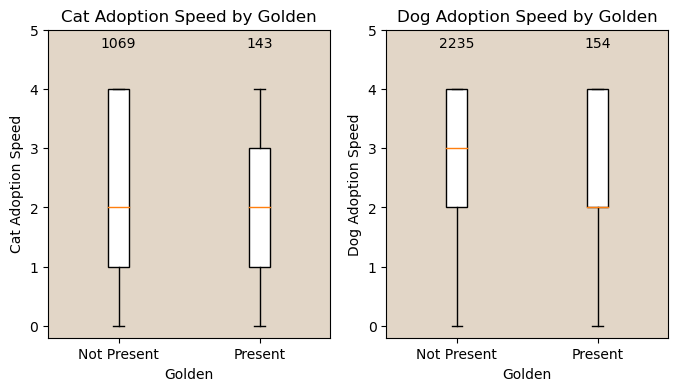

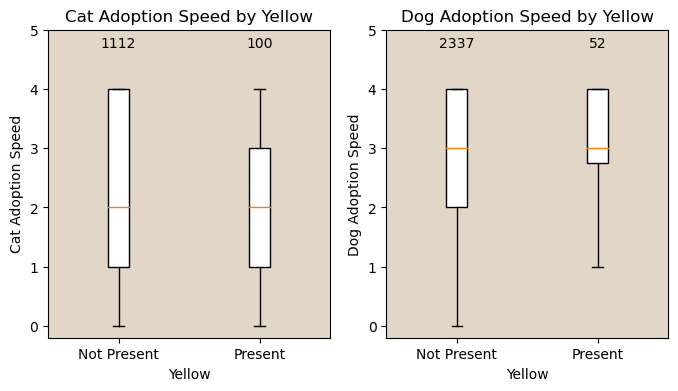

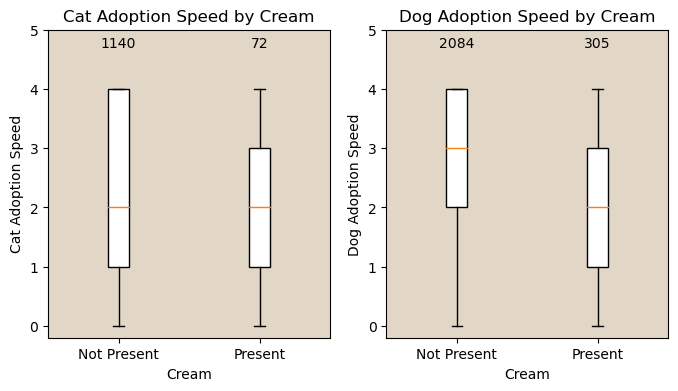

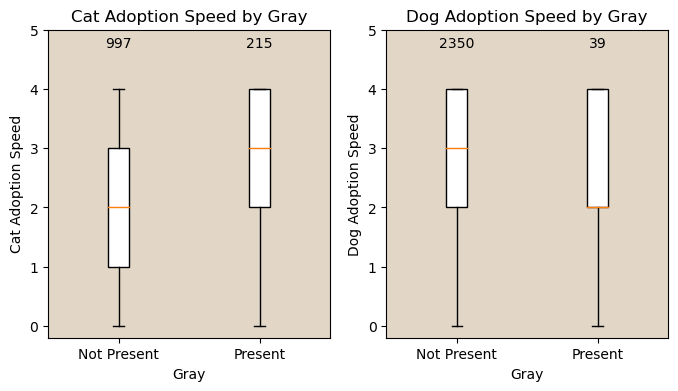

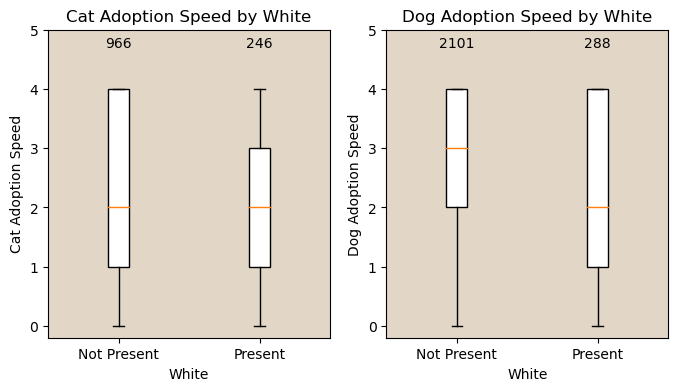

In [51]:
single_color = temp_train[temp_train.ColorCount == 1]
for color in colors_labels['ColorName']:
    label_mapping = {1: 'Present', 0: 'Not Present'}
    box_plot(label_mapping, color, single_color)

---
### Feature: Breed

**'isGeneric_Breed' - Binary(1 = generic, 0 = more_specific)**

**'{Breed_Group}' - Binary OHE (1 = breed group present, 0 = group not present)**

Unfortunately the breeds data has some challenges. Only 18% if records do not include the first four generic descriptions below.  And beyond that there are several 'breeds' that are more just descriptors of the physical attributes of the pet (color, color pattern, number of toes . . .)  

**COMMENT: Where do we want to make the cut-off between too generic and descriptive enough to consider a breed.**

| Name                           | Description                                                                                   |
|--------------------------------|-----------------------------------------------------------------------------------------------|
| **Mixed Breed**                | Mixed or unknown breed composition                                                     |
| **Domestic Long Hair**        | A long-haired cat of mixed or unknown breed                                                     |
| **Domestic Medium Hair**      | A medium-haired cat of mixed or unknown breed                                                   |
| **Domestic Short Hair**       | A short-haired cat of mixed or unknown breed                                                    |
| Snowshoe                       | A cat breed known for its distinctive white feet and colored body markings                    |
| Torbie                         | A cat with a combination of tortoiseshell and tabby coat patterns                             |
| Tuxedo                         | A cat with black and white coat markings resembling a tuxedo or formalwear                    |
| Tabby                          | A cat with a distinctive coat pattern characterized by stripes, swirls, or spots              |
| Tiger                          | A cat with a coat pattern resembling that of a wild tiger                                      |
| Calico                         | A cat with a distinctive tri-color coat pattern of orange, black, and white                   |
| Dilute Calico                  | A cat with a lighter version of the calico coat pattern, often with dilute colors             |
| Tortoiseshell                  | A cat with a coat pattern characterized by patches of orange, black, and sometimes white       |
| Dilute Tortoiseshell           | A cat with a lighter version of the tortoiseshell coat pattern, often with dilute colors       |
| Silver                         | A cat with a silver or grayish coat color                                                      |
| Extra-Toes Cat (Hemingway Polydactyl) | A cat with extra toes, often resembling thumbs, due to a genetic condition called polydactyly |

In [52]:
#creating a binary variable for generic dog breed description
generic_breeds = [307, 264, 265, 266] #ID's for Mixed Breed, and the three Domestic Hair Lengths
temp_train['isGeneric_Breed'] = temp_train[['Breed1', 'Breed2']].apply(lambda row: 1 
                               if any(breed in row.values for breed in generic_breeds) 
                               else 0, 
                               axis=1)

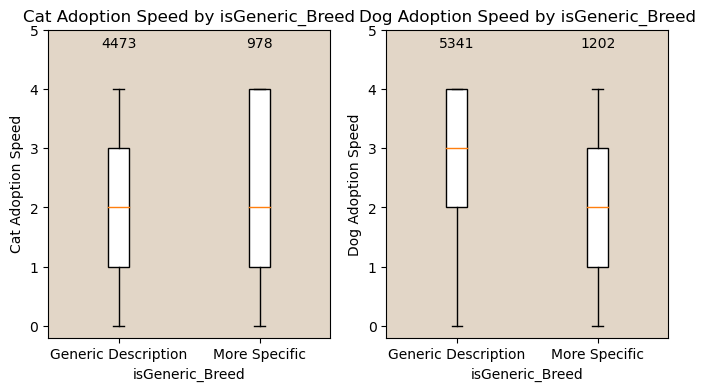

In [53]:
label_mapping = {1: 'Generic Description', 0: 'More Specific'}
box_plot(label_mapping, 'isGeneric_Breed')

In [54]:
temp_train[(train.Type == 1)]

,Unnamed: 0,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,British,European,Generic,Toy Group,Hound Group,Terrier Group,Working Group,Non-Sporting Group,Sporting Group,Herding Group
0,6786,1,7 Puppies,1,307,0,3,Brown,White,NaN,...,0,0,1,0,0,0,0,0,0,0
1,9837,1,A88,2,307,307,2,Brown,White,NaN,...,0,0,1,0,0,0,0,0,0,0
3,6556,1,Coco,2,103,307,2,Black,Brown,NaN,...,0,0,1,0,0,0,0,0,0,0
4,11322,1,Jack,2,307,0,3,Brown,Yellow,White,...,0,0,1,0,0,0,0,0,0,0
6,1643,1,NaN,1,307,0,3,Black,Brown,White,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11983,13526,1,Spotty,18,20,76,1,Golden,White,NaN,...,0,0,0,0,0,0,0,0,0,0
11984,466,1,Lucky,4,307,307,2,Brown,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
11988,11964,1,Stella,3,307,0,2,Brown,White,NaN,...,0,0,1,0,0,0,0,0,0,0
11989,5191,1,Rocky,48,189,307,1,Black,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0


In [55]:
#adding additional features from breeds dataframe
temp_train['Group'] = temp_train['Breed1'].map(breeds.set_index('BreedID')['Group'])
temp_train['Sec_Group'] = temp_train['Breed1'].map(breeds.set_index('BreedID')['Secondary_Group'])

In [56]:
#converting Breed feature to actual name of breed
for i in range(1,3):
    temp_train[f'Breed{i}'] = temp_train[f'Breed{i}'].map(breeds.set_index('BreedID')['BreedName'])

In [57]:
print("Cat Records with Other as Group:", temp_train[(temp_train.Type == 0) & (train.Group == "Other")].shape[0])
print("Dog Records without a Group:", temp_train[(temp_train.Type == 1) & (train.Group.isna())].shape[0])
temp_train[(temp_train.Type == 1) & (train.Sec_Group.isna())]

Cat Records with Other as Group: 744
Dog Records without a Group: 3


,Unnamed: 0,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,Generic,Toy Group,Hound Group,Terrier Group,Working Group,Non-Sporting Group,Sporting Group,Herding Group,Group,Sec_Group
9354,7285,1,"""Boy Boy""",72,NaN,Mixed Breed,1,Black,Brown,NaN,...,1,0,0,0,0,0,0,0,NaN,NaN
11578,1045,1,Bella 4 Months Puppy!,4,NaN,Mixed Breed,2,Brown,Golden,NaN,...,1,0,0,0,0,0,0,0,NaN,NaN
11856,391,1,Lil Milo,2,NaN,Belgian Shepherd Malinois,2,Brown,NaN,NaN,...,0,0,0,0,0,0,0,0,NaN,NaN


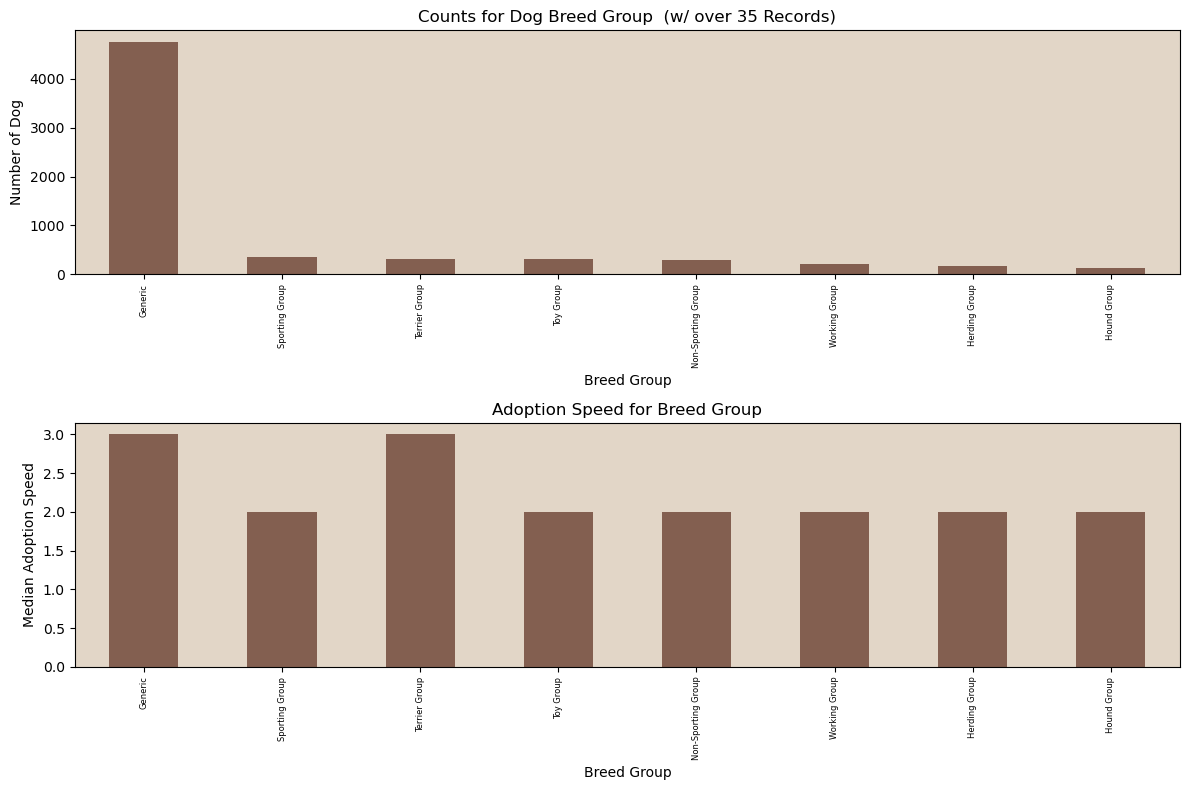

In [58]:
dist_adpt_speeds_plot(temp_train, 1, 'Group', 'Breed Group', 35)

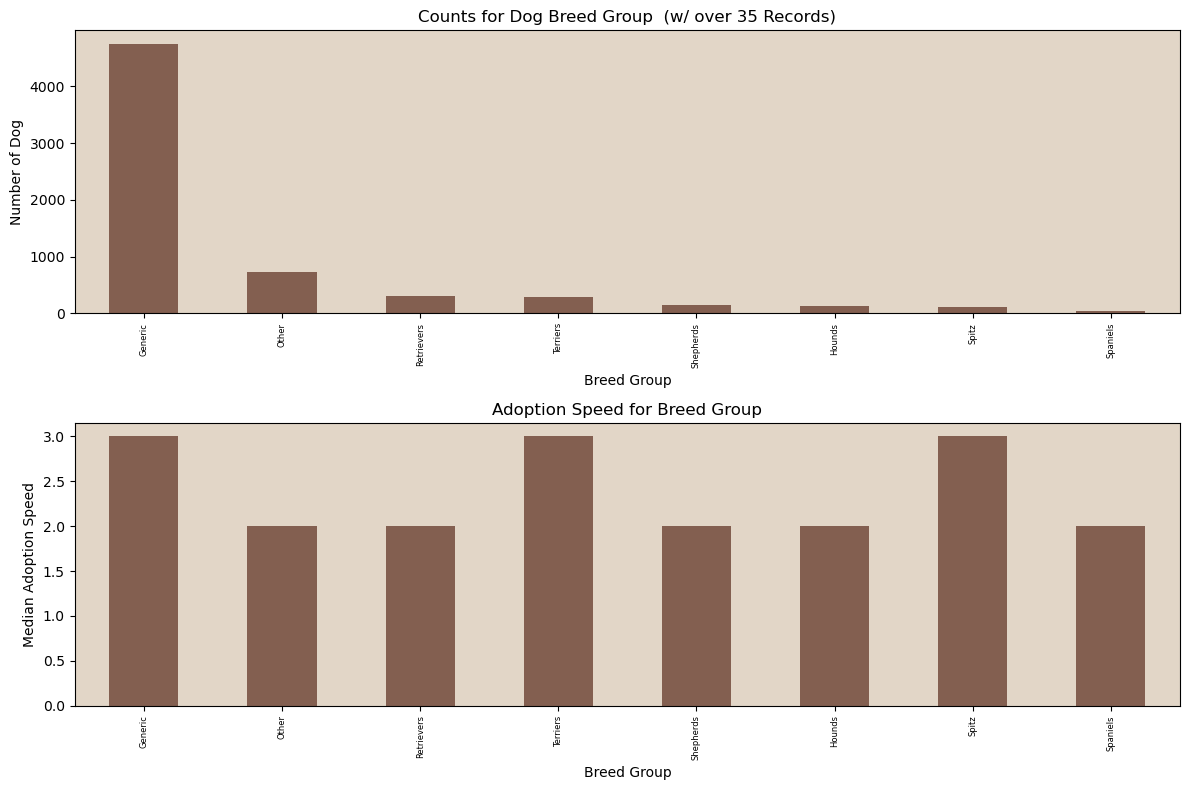

In [59]:
dist_adpt_speeds_plot(temp_train, 1, 'Sec_Group', 'Breed Group', 35)

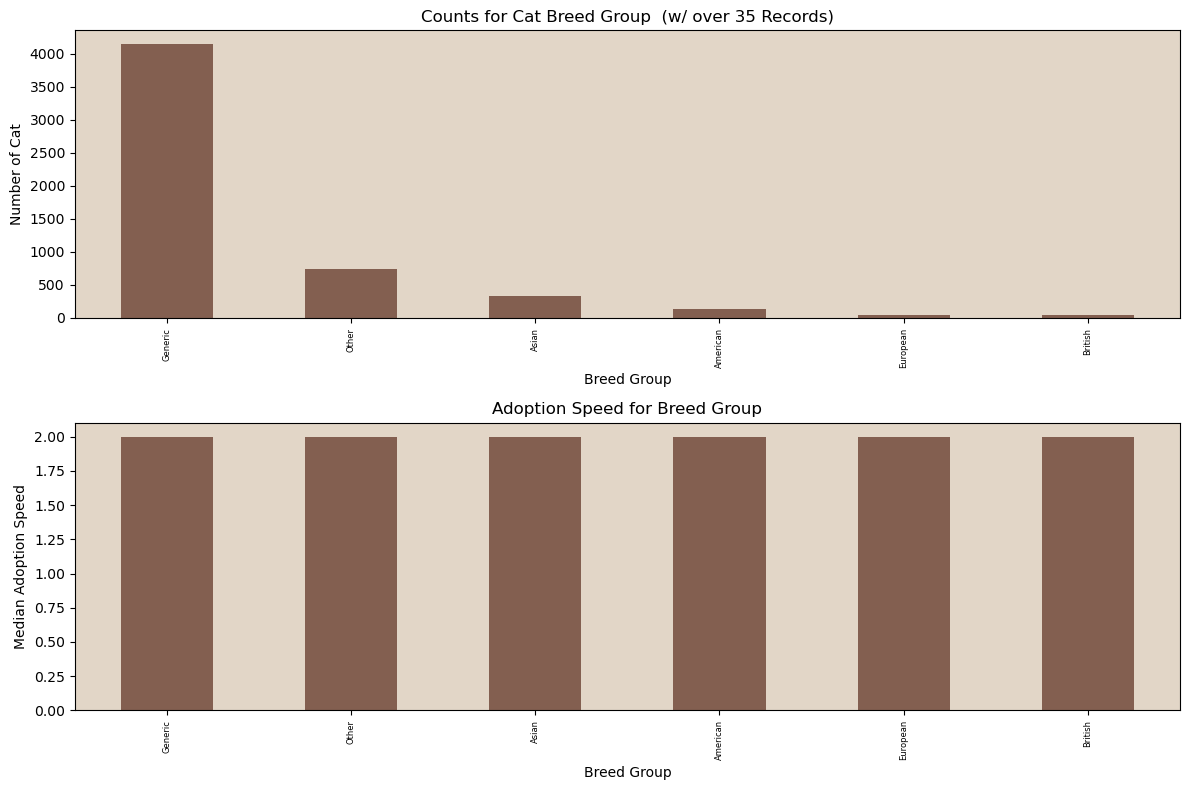

In [60]:
dist_adpt_speeds_plot(temp_train, 0, 'Group', 'Breed Group', 35)

***
# 3. Bailey EDA - Charts

### Image Metadata Exploration
All of the image metadata was obtained through Google's API

**Summary:**


**1. LabelAnnotations**  
Link: https://cloud.google.com/vision/docs/labels  

The "LabelAnnotations" contains the following data:

   - **mid**: MachineID, or, a unique identifier generated and used by a knowledge graph  
       - Link of description: https://cloud.google.com/enterprise-knowledge-graph/docs/mid
   - **description**: label/description for image from Google API
   - **score**: the confidence score of the label, from 0 (no confidence) to 1 (very high confidence)
       - NOTE: The values appear in order of descending score
   - **topicality**: relevancy of the Image Content Annotation (ICA) label to the image. It measures how important/central a label is to the overall context of a page.
       - NOTE: The values appear in order of descending topicality


**2. ImagePropertiesAnnotation**  
Link: https://cloud.google.com/vision/docs/reference/rest/v1p2beta1/images/annotate  

The "imagePropertiesAnnotation" contains:

   - **color**: RGB components of the image
   - **score**: Image-specific score for this color
   - **pixelFraction**: The fraction of pixels the color occupies in the image.
   
   
**3. Pixel / CropHintsAnnotation**
Link: https://cloud.google.com/vision/docs/detecting-crop-hints

The "CropHintsAnnotation" contains:
   - **aspectRatios**: A float that corresponds to your specified ratio(s) for your images (width:height)
   - **boundingPoly**: Coordinates and vertices of CropHints.

### Test out parsing through the json files using the first file as an example

In [42]:
# Make parameter for file names
file_id = '000aa306a-1'

# Make a dictionary from the json file
with open(f'./data/test_metadata/{file_id}.json') as f:
    dic = json.load(f)

# Close the file
f.close()  

In [43]:
# Recursive function to parse through all the keys in the json file
def iter_dict(dic):
    """
    Takes in a dictionary (from json file) and gets all of the keys
    """
    key_list = []
    
    for key in dic:
        #print(key)
        key_list.append(key)
        if isinstance(dic[key], dict):
            iter_dict(dic[key])
    return key_list


# Call function and look at keys
keys = iter_dict(dic)
keys

['labelAnnotations', 'imagePropertiesAnnotation', 'cropHintsAnnotation']

#### Loop through the dic using each key and create a single dataframe.

In [44]:
# Example: looking at the label annotations for this file
df = pd.DataFrame.from_dict(dic['labelAnnotations'])
df

,mid,description,score,topicality
0,/m/0bt9lr,dog,0.958319,0.958319
1,/m/01z5f,dog like mammal,0.941531,0.941531
2,/m/0kpmf,dog breed,0.935949,0.935949
3,/m/03d12,greyhound,0.829098,0.829098
4,/m/076zw,sighthound,0.725427,0.725427
5,/m/03ysz,italian greyhound,0.696086,0.696086
6,/m/05mqq3,snout,0.655359,0.655359
7,/m/0286819,formosan mountain dog,0.620234,0.620234
8,/m/07701,galgo español,0.594501,0.594501
9,/m/01lrl,carnivoran,0.588813,0.588813


In [45]:
# Example: looking at the label annotations for this file
df = pd.DataFrame.from_dict(dic['labelAnnotations'])
df

,mid,description,score,topicality
0,/m/0bt9lr,dog,0.958319,0.958319
1,/m/01z5f,dog like mammal,0.941531,0.941531
2,/m/0kpmf,dog breed,0.935949,0.935949
3,/m/03d12,greyhound,0.829098,0.829098
4,/m/076zw,sighthound,0.725427,0.725427
5,/m/03ysz,italian greyhound,0.696086,0.696086
6,/m/05mqq3,snout,0.655359,0.655359
7,/m/0286819,formosan mountain dog,0.620234,0.620234
8,/m/07701,galgo español,0.594501,0.594501
9,/m/01lrl,carnivoran,0.588813,0.588813


In [46]:
# iterate through other keys to see what the pattern is
print(iter_dict(dic['imagePropertiesAnnotation']))
print(iter_dict(dic['cropHintsAnnotation']))

# Make dataframe for imagePropertiesAnnotation
df2 = pd.DataFrame.from_dict(dic['imagePropertiesAnnotation']['dominantColors']['colors'])
df2

['dominantColors']
['cropHints']


,color,score,pixelFraction
0,"{'red': 21, 'green': 27, 'blue': 25}",0.619539,0.191901
1,"{'red': 37, 'green': 46, 'blue': 44}",0.291855,0.088189
2,"{'red': 76, 'green': 84, 'blue': 82}",0.027027,0.026015
3,"{'red': 110, 'green': 120, 'blue': 117}",0.022415,0.219043
4,"{'red': 29, 'green': 47, 'blue': 41}",0.015889,0.002341
5,"{'red': 17, 'green': 35, 'blue': 30}",0.010894,0.001387
6,"{'red': 99, 'green': 122, 'blue': 116}",0.006085,0.014568
7,"{'red': 139, 'green': 150, 'blue': 147}",0.003465,0.447364
8,"{'red': 74, 'green': 95, 'blue': 89}",0.002544,0.000520
9,"{'red': 168, 'green': 183, 'blue': 178}",0.000177,0.008585


In [47]:
# Make dataframe for cropHintsAnnotation
df3 = pd.DataFrame.from_dict(dic['cropHintsAnnotation']['cropHints'])
df3

,boundingPoly,confidence,importanceFraction
0,"{'vertices': [{}, {'x': 298}, {'x': 298, 'y': ...",0.8,1


#### Merge dataframes

In [48]:
# Pandas Merge on Multiple DataFrames Example
df_final1 = pd.merge(df,df2, left_index=True, right_index=True)
df_final1

,mid,description,score_x,topicality,color,score_y,pixelFraction
0,/m/0bt9lr,dog,0.958319,0.958319,"{'red': 21, 'green': 27, 'blue': 25}",0.619539,0.191901
1,/m/01z5f,dog like mammal,0.941531,0.941531,"{'red': 37, 'green': 46, 'blue': 44}",0.291855,0.088189
2,/m/0kpmf,dog breed,0.935949,0.935949,"{'red': 76, 'green': 84, 'blue': 82}",0.027027,0.026015
3,/m/03d12,greyhound,0.829098,0.829098,"{'red': 110, 'green': 120, 'blue': 117}",0.022415,0.219043
4,/m/076zw,sighthound,0.725427,0.725427,"{'red': 29, 'green': 47, 'blue': 41}",0.015889,0.002341
5,/m/03ysz,italian greyhound,0.696086,0.696086,"{'red': 17, 'green': 35, 'blue': 30}",0.010894,0.001387
6,/m/05mqq3,snout,0.655359,0.655359,"{'red': 99, 'green': 122, 'blue': 116}",0.006085,0.014568
7,/m/0286819,formosan mountain dog,0.620234,0.620234,"{'red': 139, 'green': 150, 'blue': 147}",0.003465,0.447364
8,/m/07701,galgo español,0.594501,0.594501,"{'red': 74, 'green': 95, 'blue': 89}",0.002544,0.000520
9,/m/01lrl,carnivoran,0.588813,0.588813,"{'red': 168, 'green': 183, 'blue': 178}",0.000177,0.008585


#### Make a function that does all of these things in one spot

In [49]:
def get_variables(file_id):
    """
    """
    # check if the file exists
    try:
        # Make a dictionary from the json file
        with open(f'../Dataset/test_metadata/{file_id}.json') as f:
            dic = json.load(f)
    
    # return false if the file doesn't exist (go to next PetID)
    except:
        return False
    
    # Close the file
    f.close()
    
    
    # Hard code keys because they're all the same
    # Create df to get label annotations data
    df = pd.DataFrame.from_dict(dic['labelAnnotations'])
    
    # Create df to get image properties data
    df2 = pd.DataFrame.from_dict(dic['imagePropertiesAnnotation']['dominantColors']['colors'])
    
    # Merge the two dfs
    merged_df = pd.merge(df,df2, left_index=True, right_index=True)
    
    # Return the merged df containing all data for the image
    return merged_df

In [55]:
# Second file
file_id = '000aa306a-2'

# Make a dictionary from the json file
with open(f'./data/test_metadata/{file_id}.json') as f:
    dic2 = json.load(f)

df_file2 = pd.DataFrame.from_dict(dic2['labelAnnotations'])
df2_file2 = pd.DataFrame.from_dict(dic2['imagePropertiesAnnotation']['dominantColors']['colors'])
df_final2 = pd.merge(df_file2,df2_file2, left_index=True, right_index=True)
df_final2

,mid,description,score_x,topicality,color,score_y,pixelFraction
0,/m/0bt9lr,dog,0.957361,0.957361,"{'red': 26, 'green': 25, 'blue': 32}",0.302873,0.136431
1,/m/0kpmf,dog breed,0.942680,0.942680,"{'red': 248, 'green': 248, 'blue': 250}",0.053360,0.029299
2,/m/01z5f,dog like mammal,0.910743,0.910743,"{'red': 53, 'green': 48, 'blue': 57}",0.242820,0.126073
3,/m/02xl47d,dog breed group,0.832615,0.832615,"{'red': 85, 'green': 77, 'blue': 87}",0.081983,0.079091
4,/m/0286819,formosan mountain dog,0.703304,0.703304,"{'red': 49, 'green': 47, 'blue': 65}",0.080796,0.034922
5,/m/05zmzn1,street dog,0.686828,0.686828,"{'red': 28, 'green': 27, 'blue': 43}",0.054353,0.038473
6,/m/01sc6y,patterdale terrier,0.611134,0.611134,"{'red': 123, 'green': 115, 'blue': 125}",0.047571,0.104321
7,/m/01lrl,carnivoran,0.558059,0.558059,"{'red': 202, 'green': 189, 'blue': 195}",0.031314,0.134507
8,/m/0265rtm,sporting group,0.553172,0.553172,"{'red': 166, 'green': 155, 'blue': 163}",0.026429,0.166839
9,/m/03d12,greyhound,0.539038,0.539038,"{'red': 82, 'green': 77, 'blue': 97}",0.025984,0.024268
